In [11]:
############################
#     Import modules       #
############################
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

def assign_WMH(this_dict):

    for k, v in this_dict.items():
        this_dict[k]['WMH'] = WMH_dict[k]
        
    return this_dict

def get_values_for_dict(subject_list, best_parms):

    '''This function filters the overall dictionary to create a condition specific (e.g., HC) dictionary.'''
    
    condition_dict = {}
    for k,v in best_parms.items():
        if k in subject_list:
            condition_dict[k] = v
    return condition_dict


##########################################
##          Functions                   ##
##########################################

def get_FC_phFCD_heterogeneous_across_subjects(parms_dictionary):

    '''This function returns all the FC (Pearson's rho) and phFCD (KS distance) model fits from the fitting dictionary obtained through Gustavo Patow's WholeBrain Module for 
    the case where a is fixed for all nodes in a patient, but it is differently weighted in different patients in relation to their white matter burden. 
    This dictionary's format is:
    
    fitting = {'Subj': {'FC': FC1, FC2, ... FCWs}, {'phFCD'}: phFCD1, phFCD2, ... phFCDWs}} where Ws is the length of the weights array we chose to consider.
    
    So it records all the model fits for all simulations ran with different weights.
    
    Args:
        parms_dictionary (dict): dictionary of all model fitting parameters obtained from Gustavo Patow's WholeBrain simulation module

    Returns:

        func_conn_arr (ndarray): an array of length Nsubj X len(Ws) containing all FC model fits (Pearson's rho correlation coefficients) for each subject obtained through 
        different simulations weighting a based on the white matter burden of that patient.

        func_conn_dyn_arr (ndarray): an array of length Nsubj X len(Ws) containing all phFCD model fits (KS distance) for each subject, obtained through different simulations 
        weighting a based on the white matter burden of that patient.
    
    '''
    
    func_conn = []
    func_conn_dyn = []
    WMH = []
    
    for k, v in parms_dictionary.items():

        func_conn.append(v['FC'])
        func_conn_dyn.append(v['phFCD'])
        WMH.append(v['WMH'])

    func_conn_arr = np.array(func_conn)
    func_conn_dyn_arr = np.array(func_conn_dyn)
    WMH_arr = np.array(WMH)


    return func_conn_arr, func_conn_dyn_arr, WMH

def get_best_FC_idx_best_phFCD(best_parms_dictionary, fitting_parms_dictionary):

    '''This function returns the best phFCD results from the best dictionary obtained through Gustavo Patow's WholeBrain Module and the corresponding best FC from the fitting 
    parameters dictionary.
    This dictionary's format is:
    
    fitting = {'Subj': {'FC': [best_FC, best_FC_index]}, {'phFCD'}: [best_phFCD, best_phFCD_index]}} 
    
    Args:
        parms_dictionary (dict): dictionary of best parameters of model fits obtained from Gustavo Patow's WholeBrain simulation module

    Returns:

        best_func_conn_arr (ndarray): an array of length Nsubj containing only the best FC model fit (Pearson's rho correlation coefficients) for each subject.
        
        best_func_conn_dyn_arr (ndarray): an array of length Nsubj containing only the best phFCD model fit (KS distance) for each subject.
    
    '''    
    best_func_conn = []
    best_func_conn_dyn = []
    
    for k, v in best_parms_dictionary.items():
    
        index = v['phFCD'][1]
        best_func_conn.append(fitting_parms_dictionary[k]['FC'][index])
        best_func_conn_dyn.append(v['phFCD'][0])


    return best_func_conn, best_func_conn_dyn

def get_best_FC_phFCD(best_parms_dictionary):

    '''This function returns the best FC and phFCD results from the best dictionary obtained through Gustavo Patow's WholeBrain Module. 
    This dictionary's format is:
    
    fitting = {'Subj': {'FC': [best_FC, best_FC_index]}, {'phFCD'}: [best_phFCD, best_phFCD_index]}} 
    
    Args:
        parms_dictionary (dict): dictionary of best parameters of model fits obtained from Gustavo Patow's WholeBrain simulation module

    Returns:

        best_func_conn_arr (ndarray): an array of length Nsubj containing only the best FC model fit (Pearson's rho correlation coefficients) for each subject.
        
        best_func_conn_dyn_arr (ndarray): an array of length Nsubj containing only the best phFCD model fit (KS distance) for each subject.
    
    '''    
    best_func_conn = []
    best_func_conn_dyn = []
    
    for k, v in best_parms_dictionary.items():

        best_func_conn.append(v['FC'][0])
        best_func_conn_dyn.append(v['phFCD'][0])


    return best_func_conn, best_func_conn_dyn


In [2]:
##############################
##        Load Data         ##
##############################

root_folder = '/home/riccardo/ADNI_Hopf/Results/'
base_dir = root_folder + "G_fitted_to_HC-minimalWMH/"
baseline_folder_HC_with_WMH = "10iterations_baseline_homogeneous_model_on_HC_with_WMH_subjectwise/"
baseline_folder_MCI_without_WMH = "10iterations_baseline_homogeneous_model_on_MCI_withoutWMH_subjectwise/"
baseline_folder_MCI = "10iterations_baseline_homogeneous_model_on_MCI_subjectwise/"
homogeneous_folder = "10iterations_homogeneous_model/"
heterogeneous_folder = "10iterations_heterogeneous_model/"
random_folder = "random_10iterations_model/"


###############################
### Load WMH normalized     ###
###############################

WMH_dict_file = open(root_folder + 'overall_WMH_burden_all.pkl', 'rb')
WMH_dict = pickle.load(WMH_dict_file)

##############################################################
#########      Load the files for baseline models       ######
##############################################################

# Load baseline best_parameters for HC with WMH (a = -0.02 as in literature)
base_best_parms_HC_with_WMH_file = open(base_dir + baseline_folder_HC_with_WMH + "baseline_model_best_parameters_dictionary_hc.pkl","rb")
base_best_parms_HC_with_WMH = pickle.load(base_best_parms_HC_with_WMH_file)
# Load baseline best_parameters for MCI without WMH (a = -0.027 as found)
base_best_parms_MCI_noWMH_file = open(base_dir +  baseline_folder_MCI_without_WMH + "baseline_model_best_parameters_dictionary_mci.pkl","rb")
base_best_parms_MCI_noWMH = pickle.load(base_best_parms_MCI_noWMH_file)
# Load baseline best_parameters for MCI (a = -0.02 as in literature)
base_best_parms_MCI_file = open(base_dir + baseline_folder_MCI + "baseline_model_best_parameters_dictionary_mci.pkl","rb")
base_best_parms_MCI = pickle.load(base_best_parms_MCI_file)

##############################################################
######      Load the files for homogeneous models    #########
##############################################################

# Load best_parameters for homogeneous model for HC with WMH (a = -0.02 as in literature + w*WMburden with w in range(-0.08,0.05, 0.001))
homo_best_parms_dict_file_HC = open(base_dir + homogeneous_folder + "homogeneous_model_best_parameters_dictionary_hc.pkl", 'rb')
homo_best_parms_dict_HC = pickle.load(homo_best_parms_dict_file_HC)
homo_best_parms_dict_HC = assign_WMH(homo_best_parms_dict_HC)
# Load all model fits for homogeneous model for HC with WMH (a = -0.02 as in literature + w*WMburden with w in range(-0.08,0.05, 0.001))
homo_fitting_parms_dict_file_HC = open(base_dir + homogeneous_folder + "homogeneous_model_fitting_parameters_dictionary_hc.pkl", 'rb')
homo_fitting_parms_dict_HC = pickle.load(homo_fitting_parms_dict_file_HC)
homo_fitting_parms_dict_HC = assign_WMH(homo_fitting_parms_dict_HC)

# Load best_parameters for homogeneous model for MCI (a = -0.02 as in literature + w*WMburden with w in range(-0.08,0.05, 0.001))
homo_best_parms_dict_file_MCI = open(base_dir + homogeneous_folder + "homogeneous_model_best_parameters_dictionary_mci.pkl", 'rb')
homo_best_parms_dict_MCI = pickle.load(homo_best_parms_dict_file_MCI)
homo_best_parms_dict_MCI = assign_WMH(homo_best_parms_dict_MCI)
# Load all model fits for homogeneous model for MCI (a = -0.02 as in literature + w*WMburden with w in range(-0.08,0.05, 0.001))
homo_fitting_parms_dict_file_MCI = open(base_dir + homogeneous_folder + "homogeneous_model_fitting_parameters_dictionary_mci.pkl", 'rb')
homo_fitting_parms_dict_MCI = pickle.load(homo_fitting_parms_dict_file_MCI)
homo_fitting_parms_dict_MCI = assign_WMH(homo_fitting_parms_dict_MCI)

##############################################################
######     Load the files for heterogeneous models     #######
##############################################################
# Load best_parameters for heterogeneous model for HC with WMH (ai = -0.02 as in literature + w*WMburden with w in range(-0.08,0.05, 0.001))
hetero_best_parms_dict_file_HC = open(base_dir + heterogeneous_folder +"heterogeneous_model_best_parameters_dictionary_hc.pkl", 'rb')
hetero_best_parms_dict_HC = pickle.load(hetero_best_parms_dict_file_HC)
hetero_best_parms_dict_HC = assign_WMH(hetero_best_parms_dict_HC)
# # Load all model fits for homogeneous model for HC with WMH (ai = -0.02 as in literature + w*WMburden with w in range(-0.08,0.05, 0.001))
hetero_fitting_parms_dict_file_HC = open(base_dir + heterogeneous_folder + "heterogeneous_model_fitting_parameters_dictionary_hc.pkl", 'rb')
hetero_fitting_parms_dict_HC = pickle.load(hetero_fitting_parms_dict_file_HC)
hetero_fitting_parms_dict_HC = assign_WMH(hetero_fitting_parms_dict_HC)

# # Load best_parameters for heterogeneous model for MCI (ai = -0.02 as in literature + w*WMburden with w in range(-0.08,0.05, 0.001))
hetero_best_parms_dict_file_MCI = open(base_dir + heterogeneous_folder + "heterogeneous_model_best_parameters_dictionary_mci.pkl", 'rb')
hetero_best_parms_dict_MCI = pickle.load(hetero_best_parms_dict_file_MCI)
hetero_best_parms_dict_MCI = assign_WMH(hetero_best_parms_dict_MCI)

# # Load all model fits for heterogeneous model for MCI (ai = -0.02 as in literature + w*WMburden with w in range(-0.08,0.05, 0.001))
hetero_fitting_parms_dict_file_MCI = open(base_dir + heterogeneous_folder + "heterogeneous_model_fitting_parameters_dictionary_mci.pkl", 'rb')
hetero_fitting_parms_dict_MCI = pickle.load(hetero_fitting_parms_dict_file_MCI)
hetero_fitting_parms_dict_MCI = assign_WMH(hetero_fitting_parms_dict_MCI)


##############################################################
######      Load the files for random models        ##########
##############################################################

# Load the random parameter dictionary for HC and MCI (ai = -0.02 as in literature + w*randomWMburden with w in range(-0.08,0.05, 0.001) and randomWMburden taken from a random region of another subj)
random_best_parms_dict_file_HC = open(base_dir + random_folder + "random_heterogeneous_model_best_parameters_dictionary_hc.pkl", 'rb')
random_best_parms_dict_HC = pickle.load(random_best_parms_dict_file_HC)
random_best_parms_dict_HC = assign_WMH(random_best_parms_dict_HC)

random_fitting_parms_dict_file_HC = open(base_dir + random_folder + "random_heterogeneous_model_fitting_parameters_dictionary_hc.pkl", 'rb')
random_fitting_parms_dict_HC = pickle.load(random_fitting_parms_dict_file_HC)
random_fitting_parms_dict_HC = assign_WMH(random_fitting_parms_dict_HC)

random_best_parms_dict_file_MCI = open(base_dir + random_folder +  "random_heterogeneous_model_best_parameters_dictionary_mci.pkl", 'rb')
random_best_parms_dict_MCI = pickle.load(random_best_parms_dict_file_MCI)
random_best_parms_dict_MCI = assign_WMH(random_best_parms_dict_MCI)

random_fitting_parms_dict_file_MCI = open(base_dir + random_folder +  "random_heterogeneous_model_fitting_parameters_dictionary_mci.pkl", 'rb')
random_fitting_parms_dict_MCI = pickle.load(random_fitting_parms_dict_file_MCI)
random_fitting_parms_dict_MCI = assign_WMH(random_fitting_parms_dict_MCI)

# # Load the pickled dictionary of best results obtained from the model simulation with a heterogeneous between between regions and subjects for MCI and for more negative weights of wm
# more_hetero_best_parms_dict_file_MCI = open(base_dir + "tryng_more_weights_heterogeneous_model_best_parameters_dictionary_mci.pkl", 'rb')
# more_hetero_best_parms_dict_MCI = pickle.load(more_hetero_best_parms_dict_file_MCI)
# # Load the dict of the pickled dictionary of all model fits obtained from the model simulation with a heterogeneous between regions and subjects for MCI and for more negative weights of wm
# more_hetero_fitting_parms_dict_file_MCI = open(base_dir + "trying_more_weights_heterogeneous_model_fitting_parameters_dictionary_mci.pkl", 'rb')
# more_hetero_fitting_parms_dict_MCI = pickle.load(more_hetero_fitting_parms_dict_file_MCI)


In [3]:
# Load the names of subjects divided into categories
HC_noWMH = np.load(base_dir + 'subject_list_wmh_volumes_HC_minimal.npy', allow_pickle= True)
HC_WMH = np.load(base_dir + 'subject_list_wmh_volumes_HC_other.npy', allow_pickle= True)

MCI_noWMH = [k for k, v in base_best_parms_MCI_noWMH.items()]
MCI_WMH = [k for k,v in base_best_parms_MCI.items() if k not in MCI_noWMH]


#Get the dictionary of results for different groups
homo_best_parms_dict_HC_noWMH = get_values_for_dict(HC_noWMH, homo_best_parms_dict_HC)
homo_fitting_parms_dict_HC_noWMH = get_values_for_dict(HC_noWMH, homo_fitting_parms_dict_HC)
homo_best_parms_dict_HC_with_WMH = get_values_for_dict(HC_WMH, homo_best_parms_dict_HC)
homo_fitting_parms_dict_HC_with_WMH = get_values_for_dict(HC_WMH, homo_fitting_parms_dict_HC)
homo_best_parms_dict_MCI_with_WMH = get_values_for_dict(MCI_WMH, homo_best_parms_dict_MCI)
homo_fitting_parms_dict_MCI_with_WMH = get_values_for_dict(MCI_WMH, homo_fitting_parms_dict_MCI)

hetero_best_parms_dict_HC_noWMH = get_values_for_dict(HC_noWMH, hetero_best_parms_dict_HC)
hetero_fitting_parms_dict_HC_noWMH = get_values_for_dict(HC_noWMH, hetero_fitting_parms_dict_HC)
hetero_best_parms_dict_HC_with_WMH = get_values_for_dict(HC_WMH, hetero_best_parms_dict_HC)
hetero_fitting_parms_dict_HC_with_WMH = get_values_for_dict(HC_WMH, hetero_fitting_parms_dict_HC)
hetero_best_parms_dict_MCI_with_WMH = get_values_for_dict(MCI_WMH, hetero_best_parms_dict_MCI)
hetero_fitting_parms_dict_MCI_with_WMH = get_values_for_dict(MCI_WMH, hetero_fitting_parms_dict_MCI)

random_best_parms_dict_HC_noWMH = get_values_for_dict(HC_noWMH, best_parms=random_best_parms_dict_HC)
random_fitting_parms_dict_HC_noWMH = get_values_for_dict(HC_noWMH, best_parms=random_fitting_parms_dict_HC)
random_best_parms_dict_HC_with_WMH = get_values_for_dict(HC_WMH, best_parms=random_best_parms_dict_HC)
random_fitting_parms_dict_HC_with_WMH = get_values_for_dict(HC_WMH, best_parms=random_fitting_parms_dict_HC)
random_best_parms_dict_MCI_with_WMH = get_values_for_dict(MCI_WMH, best_parms=random_best_parms_dict_MCI)
random_fitting_parms_dict_MCI_with_WMH = get_values_for_dict(MCI_WMH, best_parms=random_fitting_parms_dict_MCI)


In [5]:
# Get the subjectwise results for MCI without WMH of the baseline model with a = -0.027 and G = 2.9
base_FC_MCI_noWMH, base_phFCD_MCI_noWMH = get_best_FC_phFCD(base_best_parms_MCI_noWMH) 

In [6]:
# Homogeneous model

# This is the same set of white matter hyperintensities weights that we used in the simulation. We need it to get the weights indices
homo_wmWs = np.round(np.arange(-0.08,0.050,0.001), 4)

# Get the FC and phFCD for each specific group
homo_FC_HC, homo_phFCD_HC, WMH_HC = get_FC_phFCD_heterogeneous_across_subjects(homo_fitting_parms_dict_HC_noWMH)
homo_FC_HC_WMH, homo_phFCD_HC_WMH, WMH_HC_with_WMH = get_FC_phFCD_heterogeneous_across_subjects(homo_fitting_parms_dict_HC_with_WMH)
homo_FC_MCI_WMH, homo_phFCD_MCI_WMH, WMH_MCI = get_FC_phFCD_heterogeneous_across_subjects(homo_fitting_parms_dict_MCI_with_WMH)

# Calculate the means and 95% CI for FC and phFCD for each weight (supposing that there is a overall relation between WMH load and the bifurcation parameters)
homo_FC_HC_mean = homo_FC_HC.mean(axis = 0)
homo_FC_HC_WMH_mean = homo_FC_HC_WMH.mean(axis = 0)
homo_FC_MCI_WMH_mean = homo_FC_MCI_WMH.mean(axis = 0)

homo_FC_HC_ci = 1.96 * np.std(homo_FC_HC, axis = 0)/np.sqrt(len(homo_wmWs))
homo_FC_HC_WMH_ci = 1.96 * np.std(homo_FC_HC_WMH, axis = 0)/np.sqrt(len(homo_wmWs))
homo_FC_MCI_WMH_ci = 1.96 * np.std(homo_FC_MCI_WMH, axis = 0)/np.sqrt(len(homo_wmWs))

homo_phFCD_HC_mean = homo_phFCD_HC.mean(axis = 0)
homo_phFCD_HC_WMH_mean = homo_phFCD_HC_WMH.mean(axis = 0)
homo_phFCD_MCI_WMH_mean = homo_phFCD_MCI_WMH.mean(axis = 0)

homo_phFCD_HC_ci = 1.96 * np.std(homo_phFCD_HC, axis = 0)/np.sqrt(len(homo_wmWs))
homo_phFCD_HC_WMH_ci = 1.96 * np.std(homo_phFCD_HC_WMH, axis = 0)/np.sqrt(len(homo_wmWs))
homo_phFCD_MCI_WMH_ci = 1.96 * np.std(homo_phFCD_MCI_WMH, axis = 0)/np.sqrt(len(homo_wmWs))


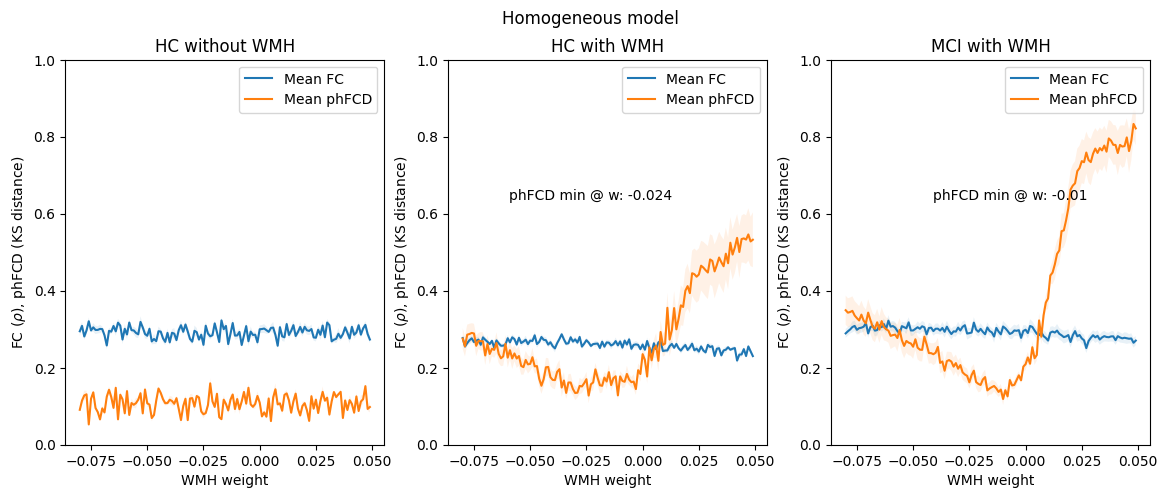

In [7]:
# Plot the results
homo_figure, homo_axis = plt.subplots(1, 3, figsize = (14,5))
homo_axis[0].plot(homo_wmWs, homo_FC_HC_mean, label = 'Mean FC')
homo_axis[0].fill_between(homo_wmWs, (homo_FC_HC_mean-homo_FC_HC_ci), (homo_FC_HC_mean+homo_FC_HC_ci), alpha=.1) 
homo_axis[0].plot(homo_wmWs, homo_phFCD_HC_mean, label = 'Mean phFCD') 
homo_axis[0].fill_between(homo_wmWs, (homo_phFCD_HC_mean-homo_phFCD_HC_ci), (homo_phFCD_HC_mean+homo_phFCD_HC_ci), alpha=.1)
homo_axis[0].set_ylim(0,1) # same y limits for all
homo_axis[0].legend()
homo_axis[0].set_title('HC without WMH')

homo_axis[1].plot(homo_wmWs, homo_FC_HC_WMH_mean, label = 'Mean FC')
homo_axis[1].fill_between(homo_wmWs, (homo_FC_HC_WMH_mean-homo_FC_HC_WMH_ci), (homo_FC_HC_WMH_mean+homo_FC_HC_WMH_ci), alpha=.1) # make the area between the upper CI and lower CI shaded.
homo_axis[1].plot(homo_wmWs, homo_phFCD_HC_WMH_mean, label = 'Mean phFCD')
homo_axis[1].fill_between(homo_wmWs, (homo_phFCD_HC_WMH_mean-homo_phFCD_HC_WMH_ci), (homo_phFCD_HC_WMH_mean+homo_phFCD_HC_WMH_ci), alpha=.1)
homo_axis[1].set_ylim(0,1)
homo_axis[1].legend()
homo_axis[1].set_title('HC with WMH')

homo_axis[2].plot(homo_wmWs, homo_FC_MCI_WMH_mean, label = 'Mean FC')
homo_axis[2].fill_between(homo_wmWs, (homo_FC_MCI_WMH_mean-homo_FC_MCI_WMH_ci), (homo_FC_MCI_WMH_mean+homo_FC_MCI_WMH_ci), alpha=.1)
homo_axis[2].plot(homo_wmWs, homo_phFCD_MCI_WMH_mean, label = 'Mean phFCD')
homo_axis[2].fill_between(homo_wmWs, (homo_phFCD_MCI_WMH_mean-homo_phFCD_MCI_WMH_ci), (homo_phFCD_MCI_WMH_mean+homo_phFCD_MCI_WMH_ci), alpha=.1)
homo_axis[2].set_ylim(0,1)
homo_axis[2].legend()
homo_axis[2].set_title('MCI with WMH')

homo_axis[0].set_xlabel('WMH weight')
homo_axis[1].set_xlabel('WMH weight')
homo_axis[2].set_xlabel('WMH weight')

homo_axis[0].set_ylabel(r'FC ($\rho$), phFCD (KS distance)')
homo_axis[1].set_ylabel(r'FC ($\rho$), phFCD (KS distance)')
homo_axis[2].set_ylabel(r'FC ($\rho$), phFCD (KS distance)')


homo_txt_HC_WMH=f'phFCD min @ w: {homo_wmWs[homo_phFCD_HC_WMH_mean.argmin()]}' # adds an explanatory note
plt.figtext(0.5, 0.6, homo_txt_HC_WMH, wrap= True, horizontalalignment='center', fontsize=10)

homo_txt_MCI=f'phFCD min @ w: {homo_wmWs[homo_phFCD_MCI_WMH_mean.argmin()]}' # adds an explanatory note
plt.figtext(0.8, 0.6, homo_txt_MCI, wrap= True, horizontalalignment='center', fontsize=10)


homo_figure.suptitle("Homogeneous model")
# Save figure
plt.savefig(base_dir + '/Plots/plot_results_homogeneous_model.png')

In [8]:
# ## Single subject plots HC
# fig, axis = plt.subplots(1, 6, figsize = (20, 4))

# for i in range(len(homo_FC_HC_WMH)):

#         axis[i].plot(wmWs, homo_FC_HC_WMH[i], label = 'Mean FC')
#         axis[i].plot(wmWs, homo_phFCD_HC_WMH[i], label = 'Mean phFCD')
#         axis[i].set_ylim(0,1)


# axis[0].legend()

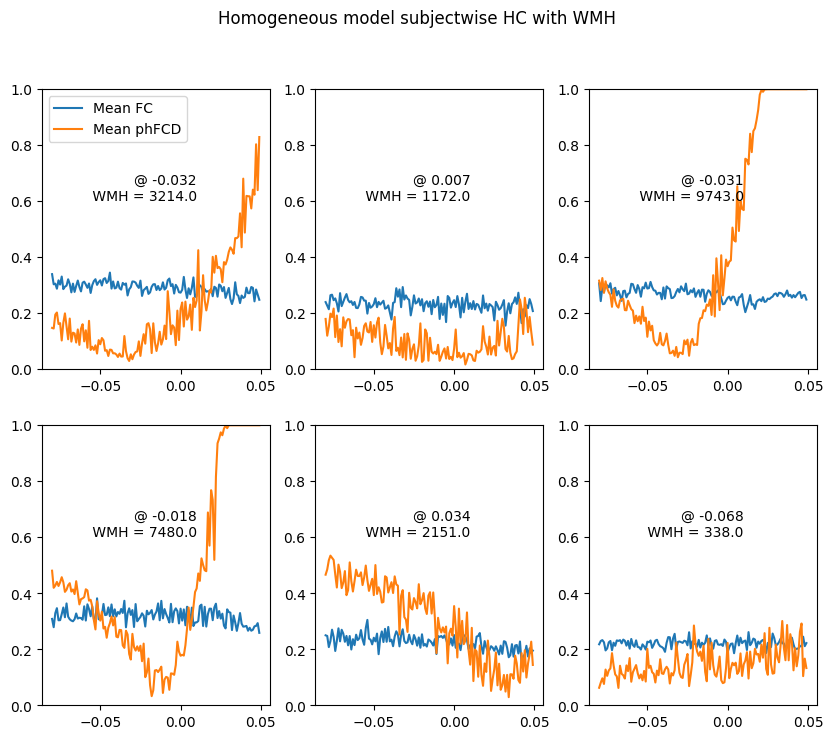

In [9]:
## Single subject plots HC homogeneous

idx_list1 = [0, 1, 2]
values_idx1 = [0, 1, 2]

idx_list2 = [0, 1, 2]
values_idx2 = [3, 4, 5]

plot_zip1 = zip(idx_list1, values_idx1)
plot_zip2 = zip(idx_list2, values_idx2)

fig, axis = plt.subplots(2, 3, figsize = (10, 8))

for i, v in plot_zip1:
        axis[0][i].plot(homo_wmWs, homo_FC_HC_WMH[v], label = 'Mean FC')
        axis[0][i].plot(homo_wmWs, homo_phFCD_HC_WMH[v], label = 'Mean phFCD')
        axis[0][i].set_ylim(0,1)
        axis[0][i].text(.01, .7, f'@ {homo_wmWs[homo_phFCD_HC_WMH[v].argmin()]}\n WMH = {WMH_HC_with_WMH[v]}',
                horizontalalignment='right',
                verticalalignment='top')        
for i, v in plot_zip2:
        axis[1][i].plot(homo_wmWs, homo_FC_HC_WMH[v], label = 'Mean FC')
        axis[1][i].plot(homo_wmWs, homo_phFCD_HC_WMH[v], label = 'Mean phFCD')
        axis[1][i].set_ylim(0,1)
        axis[1][i].text(.01, .7, f'@ {homo_wmWs[homo_phFCD_HC_WMH[v].argmin()]}\n WMH = {WMH_HC_with_WMH[v]}',
                horizontalalignment='right',
                verticalalignment='top')        

fig.suptitle("Homogeneous model subjectwise HC with WMH")
plt.savefig(base_dir + '/Plots/plot_results_homogeneous_model_subjectwise_HCwithWMH.png')
axis[0][0].legend()

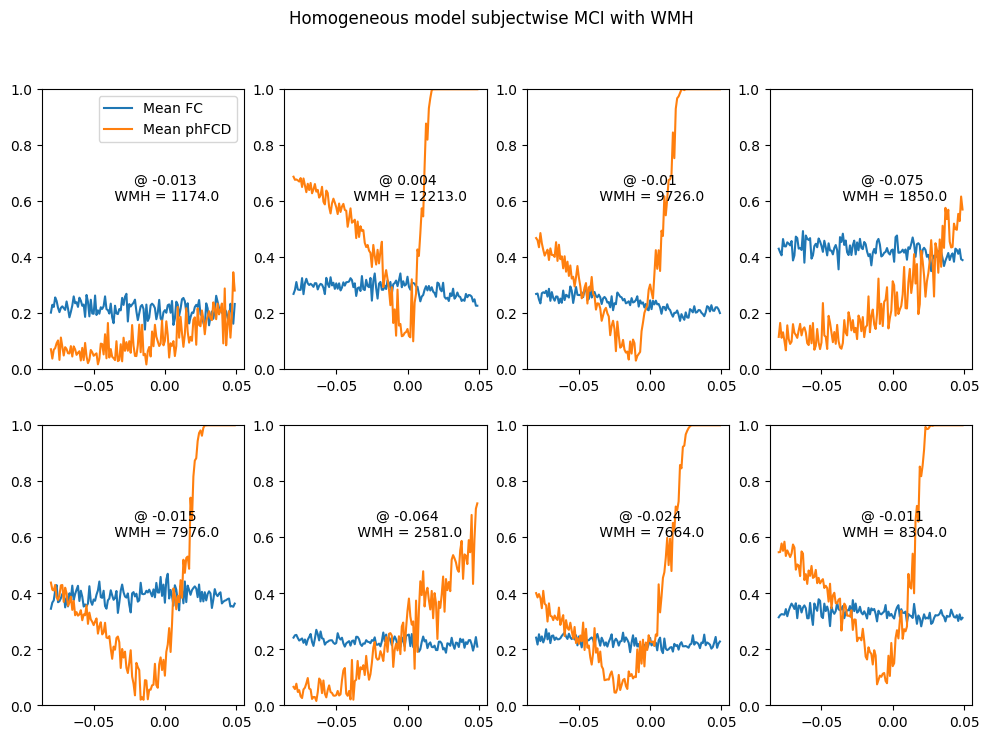

In [10]:
## Single subject plots MCI homogeneous

idx_list1 = [0, 1, 2, 3]
values_idx1 = [0, 1, 2, 3]

idx_list2 = [0, 1, 2, 3]
values_idx2 = [4, 5, 6, 7]

plot_zip1 = zip(idx_list1, values_idx1)
plot_zip2 = zip(idx_list2, values_idx2)


fig, axis = plt.subplots(2, 4, figsize = (12, 8))

for i, v in plot_zip1:
        axis[0][i].plot(homo_wmWs, homo_FC_MCI_WMH[v], label = 'Mean FC')
        axis[0][i].plot(homo_wmWs, homo_phFCD_MCI_WMH[v], label = 'Mean phFCD')
        axis[0][i].set_ylim(0,1)
        axis[0][i].text(0, 0.7, f'@ {homo_wmWs[homo_phFCD_MCI_WMH[v].argmin()]}\n WMH = {WMH_MCI[v]}',
        horizontalalignment='center',
        verticalalignment='top')   

for i, v in plot_zip2:
        axis[1][i].plot(homo_wmWs, homo_FC_MCI_WMH[v], label = 'Mean FC')
        axis[1][i].plot(homo_wmWs, homo_phFCD_MCI_WMH[v], label = 'Mean phFCD')
        axis[1][i].set_ylim(0,1)
        axis[1][i].text(0, .7, f'@ {homo_wmWs[homo_phFCD_MCI_WMH[v].argmin()]}\n WMH = {WMH_MCI[v]}',
                        horizontalalignment='center',
                        verticalalignment='top')   



fig.suptitle("Homogeneous model subjectwise MCI with WMH")
plt.savefig(base_dir + '/Plots/plot_results_homogeneous_model_subjectwise_MCI_withWMH.png')
axis[0][0].legend()

In [11]:
# heterogeneous model

# This is the same set of white matter hyperintensities weights that we used in the simulation. We need it to get the weights indices
hetero_wmWs = np.round(np.arange(-0.08,0.0501,0.001), 4)

# Get the FC and phFCD for each specific group
hetero_FC_HC, hetero_phFCD_HC, WMH_HC = get_FC_phFCD_heterogeneous_across_subjects(hetero_fitting_parms_dict_HC_noWMH)
hetero_FC_HC_WMH, hetero_phFCD_HC_WMH, WMH_HC_with_WMH = get_FC_phFCD_heterogeneous_across_subjects(hetero_fitting_parms_dict_HC_with_WMH)
hetero_FC_MCI_WMH, hetero_phFCD_MCI_WMH, WMH_MCI = get_FC_phFCD_heterogeneous_across_subjects(hetero_fitting_parms_dict_MCI_with_WMH)

# Calculate the means and 95% CI for FC and phFCD for each weight (supposing that there is a overall relation between WMH load and the bifurcation parameters)
hetero_FC_HC_mean = hetero_FC_HC.mean(axis = 0)
hetero_FC_HC_WMH_mean = hetero_FC_HC_WMH.mean(axis = 0)
hetero_FC_MCI_WMH_mean = hetero_FC_MCI_WMH.mean(axis = 0)

hetero_FC_HC_ci = 1.96 * np.std(hetero_FC_HC, axis = 0)/np.sqrt(len(hetero_wmWs))
hetero_FC_HC_WMH_ci = 1.96 * np.std(hetero_FC_HC_WMH, axis = 0)/np.sqrt(len(hetero_wmWs))
hetero_FC_MCI_WMH_ci = 1.96 * np.std(hetero_FC_MCI_WMH, axis = 0)/np.sqrt(len(hetero_wmWs))

hetero_phFCD_HC_mean = hetero_phFCD_HC.mean(axis = 0)
hetero_phFCD_HC_WMH_mean = hetero_phFCD_HC_WMH.mean(axis = 0)
hetero_phFCD_MCI_WMH_mean = hetero_phFCD_MCI_WMH.mean(axis = 0)

hetero_phFCD_HC_ci = 1.96 * np.std(hetero_phFCD_HC, axis = 0)/np.sqrt(len(hetero_wmWs))
hetero_phFCD_HC_WMH_ci = 1.96 * np.std(hetero_phFCD_HC_WMH, axis = 0)/np.sqrt(len(hetero_wmWs))
hetero_phFCD_MCI_WMH_ci = 1.96 * np.std(hetero_phFCD_MCI_WMH, axis = 0)/np.sqrt(len(hetero_wmWs))


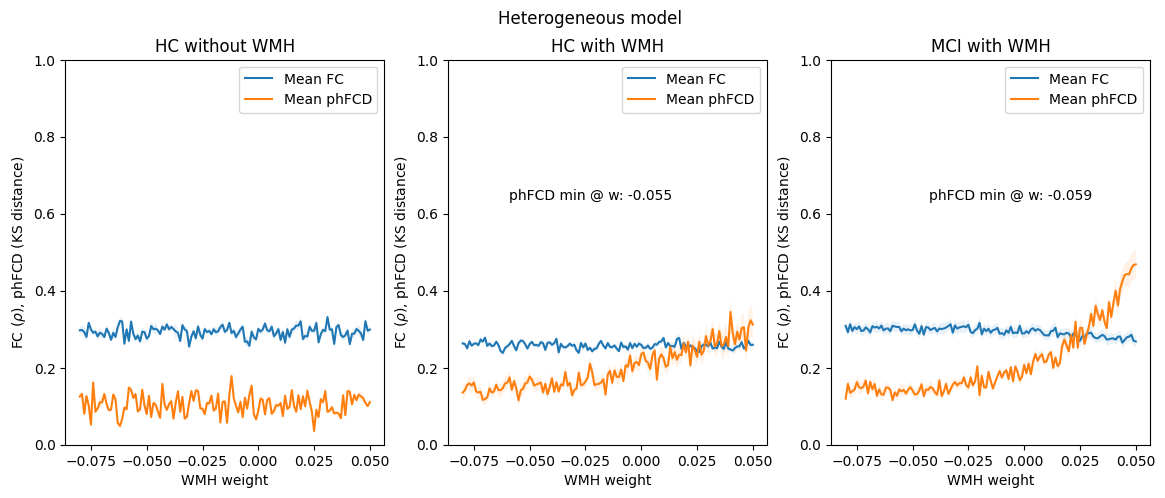

In [12]:
# Plot the results
hetero_figure, hetero_axis = plt.subplots(1, 3, figsize = (14,5))
hetero_axis[0].plot(hetero_wmWs, hetero_FC_HC_mean, label = 'Mean FC')
hetero_axis[0].fill_between(hetero_wmWs, (hetero_FC_HC_mean-hetero_FC_HC_ci), (hetero_FC_HC_mean+hetero_FC_HC_ci), alpha=.1) 
hetero_axis[0].plot(hetero_wmWs, hetero_phFCD_HC_mean, label = 'Mean phFCD') 
hetero_axis[0].fill_between(hetero_wmWs, (hetero_phFCD_HC_mean-hetero_phFCD_HC_ci), (hetero_phFCD_HC_mean+hetero_phFCD_HC_ci), alpha=.1)
hetero_axis[0].set_ylim(0,1) # same y limits for all
hetero_axis[0].legend()
hetero_axis[0].set_title('HC without WMH')

hetero_axis[1].plot(hetero_wmWs, hetero_FC_HC_WMH_mean, label = 'Mean FC')
hetero_axis[1].fill_between(hetero_wmWs, (hetero_FC_HC_WMH_mean-hetero_FC_HC_WMH_ci), (hetero_FC_HC_WMH_mean+hetero_FC_HC_WMH_ci), alpha=.1) # make the area between the upper CI and lower CI shaded.
hetero_axis[1].plot(hetero_wmWs, hetero_phFCD_HC_WMH_mean, label = 'Mean phFCD')
hetero_axis[1].fill_between(hetero_wmWs, (hetero_phFCD_HC_WMH_mean-hetero_phFCD_HC_WMH_ci), (hetero_phFCD_HC_WMH_mean+hetero_phFCD_HC_WMH_ci), alpha=.1)
hetero_axis[1].set_ylim(0,1)
hetero_axis[1].legend()
hetero_axis[1].set_title('HC with WMH')

hetero_axis[2].plot(hetero_wmWs, hetero_FC_MCI_WMH_mean, label = 'Mean FC')
hetero_axis[2].fill_between(hetero_wmWs, (hetero_FC_MCI_WMH_mean-hetero_FC_MCI_WMH_ci), (hetero_FC_MCI_WMH_mean+hetero_FC_MCI_WMH_ci), alpha=.1)
hetero_axis[2].plot(hetero_wmWs, hetero_phFCD_MCI_WMH_mean, label = 'Mean phFCD')
hetero_axis[2].fill_between(hetero_wmWs, (hetero_phFCD_MCI_WMH_mean-hetero_phFCD_MCI_WMH_ci), (hetero_phFCD_MCI_WMH_mean+hetero_phFCD_MCI_WMH_ci), alpha=.1)
hetero_axis[2].set_ylim(0,1)
hetero_axis[2].legend()
hetero_axis[2].set_title('MCI with WMH')

hetero_axis[0].set_xlabel('WMH weight')
hetero_axis[1].set_xlabel('WMH weight')
hetero_axis[2].set_xlabel('WMH weight')

hetero_axis[0].set_ylabel(r'FC ($\rho$), phFCD (KS distance)')
hetero_axis[1].set_ylabel(r'FC ($\rho$), phFCD (KS distance)')
hetero_axis[2].set_ylabel(r'FC ($\rho$), phFCD (KS distance)')


hetero_txt_HC_WMH=f'phFCD min @ w: {hetero_wmWs[hetero_phFCD_HC_WMH_mean.argmin()]}' # adds an explanatory note
plt.figtext(0.5, 0.6, hetero_txt_HC_WMH, wrap= True, horizontalalignment='center', fontsize=10)

hetero_txt_MCI=f'phFCD min @ w: {hetero_wmWs[hetero_phFCD_MCI_WMH_mean.argmin()]}' # adds an explanatory note
plt.figtext(0.8, 0.6, hetero_txt_MCI, wrap= True, horizontalalignment='center', fontsize=10)


hetero_figure.suptitle("Heterogeneous model")
# Save figure
plt.savefig(base_dir + '/Plots/plot_results_heterogeneous_model.png')

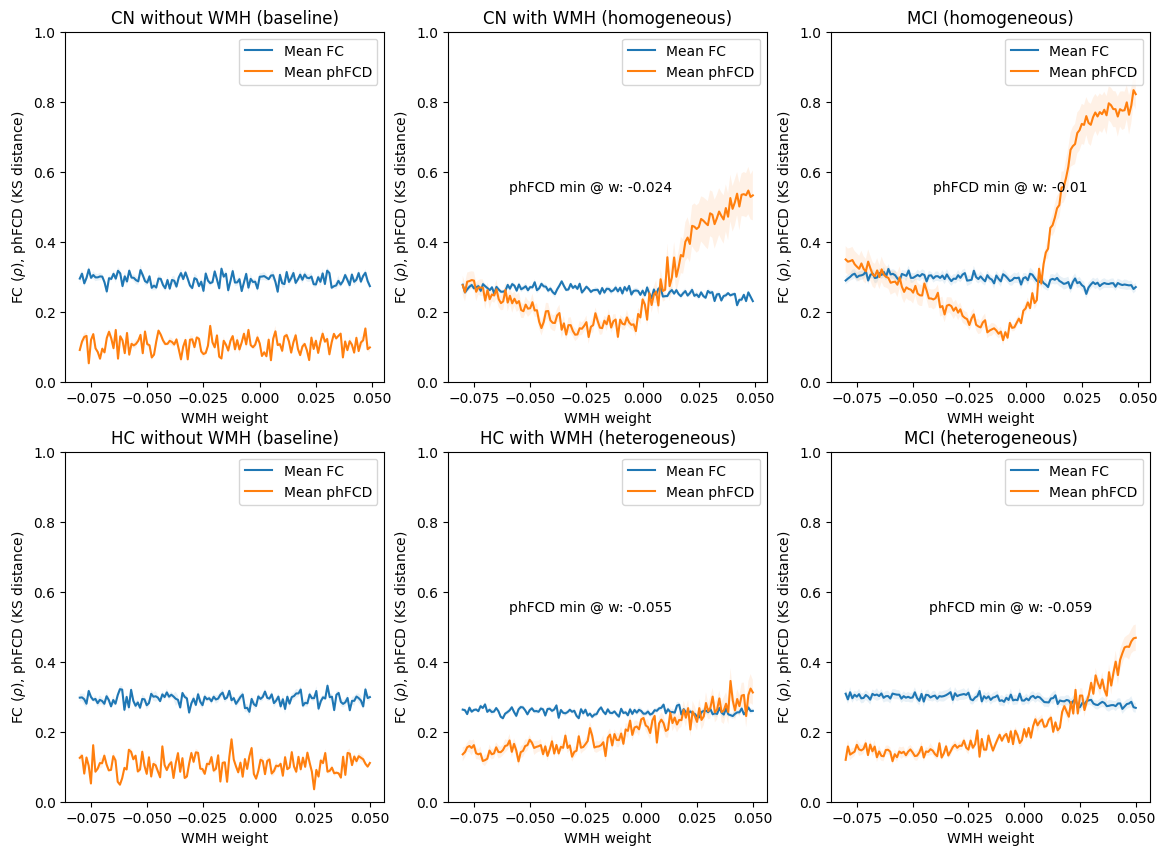

In [13]:


# Plot the results
figure, axis = plt.subplots(2, 3, figsize = (14,10))
axis[0][0].plot(homo_wmWs, homo_FC_HC_mean, label = 'Mean FC')
axis[0][0].fill_between(homo_wmWs, (homo_FC_HC_mean-homo_FC_HC_ci), (homo_FC_HC_mean+homo_FC_HC_ci), alpha=.1) 
axis[0][0].plot(homo_wmWs, homo_phFCD_HC_mean, label = 'Mean phFCD') 
axis[0][0].fill_between(homo_wmWs, (homo_phFCD_HC_mean-homo_phFCD_HC_ci), (homo_phFCD_HC_mean+homo_phFCD_HC_ci), alpha=.1)
axis[0][0].set_ylim(0,1) # same y limits for all
axis[0][0].legend()
axis[0][0].set_title('CN without WMH (baseline)')

axis[0][1].plot(homo_wmWs, homo_FC_HC_WMH_mean, label = 'Mean FC')
axis[0][1].fill_between(homo_wmWs, (homo_FC_HC_WMH_mean-homo_FC_HC_WMH_ci), (homo_FC_HC_WMH_mean+homo_FC_HC_WMH_ci), alpha=.1) # make the area between the upper CI and lower CI shaded.
axis[0][1].plot(homo_wmWs, homo_phFCD_HC_WMH_mean, label = 'Mean phFCD')
axis[0][1].fill_between(homo_wmWs, (homo_phFCD_HC_WMH_mean-homo_phFCD_HC_WMH_ci), (homo_phFCD_HC_WMH_mean+homo_phFCD_HC_WMH_ci), alpha=.1)
axis[0][1].set_ylim(0,1)
axis[0][1].legend()
axis[0][1].set_title('CN with WMH (homogeneous)')

axis[0][2].plot(homo_wmWs, homo_FC_MCI_WMH_mean, label = 'Mean FC')
axis[0][2].fill_between(homo_wmWs, (homo_FC_MCI_WMH_mean-homo_FC_MCI_WMH_ci), (homo_FC_MCI_WMH_mean+homo_FC_MCI_WMH_ci), alpha=.1)
axis[0][2].plot(homo_wmWs, homo_phFCD_MCI_WMH_mean, label = 'Mean phFCD')
axis[0][2].fill_between(homo_wmWs, (homo_phFCD_MCI_WMH_mean-homo_phFCD_MCI_WMH_ci), (homo_phFCD_MCI_WMH_mean+homo_phFCD_MCI_WMH_ci), alpha=.1)
axis[0][2].set_ylim(0,1)
axis[0][2].legend()
axis[0][2].set_title('MCI (homogeneous)')

axis[0][0].set_xlabel('WMH weight')
axis[0][1].set_xlabel('WMH weight')
axis[0][2].set_xlabel('WMH weight')

axis[0][0].set_ylabel(r'FC ($\rho$), phFCD (KS distance)')
axis[0][1].set_ylabel(r'FC ($\rho$), phFCD (KS distance)')
axis[0][2].set_ylabel(r'FC ($\rho$), phFCD (KS distance)')


txt_HC_WMH1=f'phFCD min @ w: {homo_wmWs[homo_phFCD_HC_WMH_mean.argmin()]}' # adds an explanatory note
plt.figtext(0.5, 0.72, txt_HC_WMH1, wrap= True, horizontalalignment='center', fontsize=10)

txt_MCI1=f'phFCD min @ w: {homo_wmWs[homo_phFCD_MCI_WMH_mean.argmin()]}' # adds an explanatory note
plt.figtext(0.8, 0.72, txt_MCI1, wrap= True, horizontalalignment='center', fontsize=10)

# Plot the results

axis[1][0].plot(hetero_wmWs, hetero_FC_HC_mean, label = 'Mean FC')
axis[1][0].fill_between(hetero_wmWs, (hetero_FC_HC_mean-hetero_FC_HC_ci), (hetero_FC_HC_mean+hetero_FC_HC_ci), alpha=.1) 
axis[1][0].plot(hetero_wmWs, hetero_phFCD_HC_mean, label = 'Mean phFCD') 
axis[1][0].fill_between(hetero_wmWs, (hetero_phFCD_HC_mean-hetero_phFCD_HC_ci), (hetero_phFCD_HC_mean+hetero_phFCD_HC_ci), alpha=.1)
axis[1][0].set_ylim(0,1) # same y limits for all
axis[1][0].legend()
axis[1][0].set_title('HC without WMH (baseline)')
axis[1][1].plot(hetero_wmWs, hetero_FC_HC_WMH_mean, label = 'Mean FC')
axis[1][1].fill_between(hetero_wmWs, (hetero_FC_HC_WMH_mean-hetero_FC_HC_WMH_ci), (hetero_FC_HC_WMH_mean+hetero_FC_HC_WMH_ci), alpha=.1) # make the area between the upper CI and lower CI shaded.
axis[1][1].plot(hetero_wmWs, hetero_phFCD_HC_WMH_mean, label = 'Mean phFCD')
axis[1][1].fill_between(hetero_wmWs, (hetero_phFCD_HC_WMH_mean-hetero_phFCD_HC_WMH_ci), (hetero_phFCD_HC_WMH_mean+hetero_phFCD_HC_WMH_ci), alpha=.1)
axis[1][1].set_ylim(0,1)
axis[1][1].legend()
axis[1][1].set_title('HC with WMH (heterogeneous)')

axis[1][2].plot(hetero_wmWs, hetero_FC_MCI_WMH_mean, label = 'Mean FC')
axis[1][2].fill_between(hetero_wmWs, (hetero_FC_MCI_WMH_mean-hetero_FC_MCI_WMH_ci), (hetero_FC_MCI_WMH_mean+hetero_FC_MCI_WMH_ci), alpha=.1)
axis[1][2].plot(hetero_wmWs, hetero_phFCD_MCI_WMH_mean, label = 'Mean phFCD')
axis[1][2].fill_between(hetero_wmWs, (hetero_phFCD_MCI_WMH_mean-hetero_phFCD_MCI_WMH_ci), (hetero_phFCD_MCI_WMH_mean+hetero_phFCD_MCI_WMH_ci), alpha=.1)
axis[1][2].set_ylim(0,1)
axis[1][2].legend()
axis[1][2].set_title('MCI (heterogeneous)')

axis[1][0].set_xlabel('WMH weight')
axis[1][1].set_xlabel('WMH weight')
axis[1][2].set_xlabel('WMH weight')

axis[1][0].set_ylabel(r'FC ($\rho$), phFCD (KS distance)')
axis[1][1].set_ylabel(r'FC ($\rho$), phFCD (KS distance)')
axis[1][2].set_ylabel(r'FC ($\rho$), phFCD (KS distance)')

txt_HC_WMH2=f'phFCD min @ w: {hetero_wmWs[hetero_phFCD_HC_WMH_mean.argmin()]}' # adds an explanatory note
plt.figtext(0.5, 0.3, txt_HC_WMH2, wrap= True, horizontalalignment='center', fontsize=10)

txt_MCI2=f'phFCD min @ w: {hetero_wmWs[hetero_phFCD_MCI_WMH_mean.argmin()]}' # adds an explanatory note
plt.figtext(0.8, 0.3, txt_MCI2, wrap= True, horizontalalignment='center', fontsize=10)

# figure.suptitle("Heterogeneous model")

# Save figure
plt.savefig(base_dir + '/Plots/plot_results_combined_homogeneous_heterogeneous_model.png')

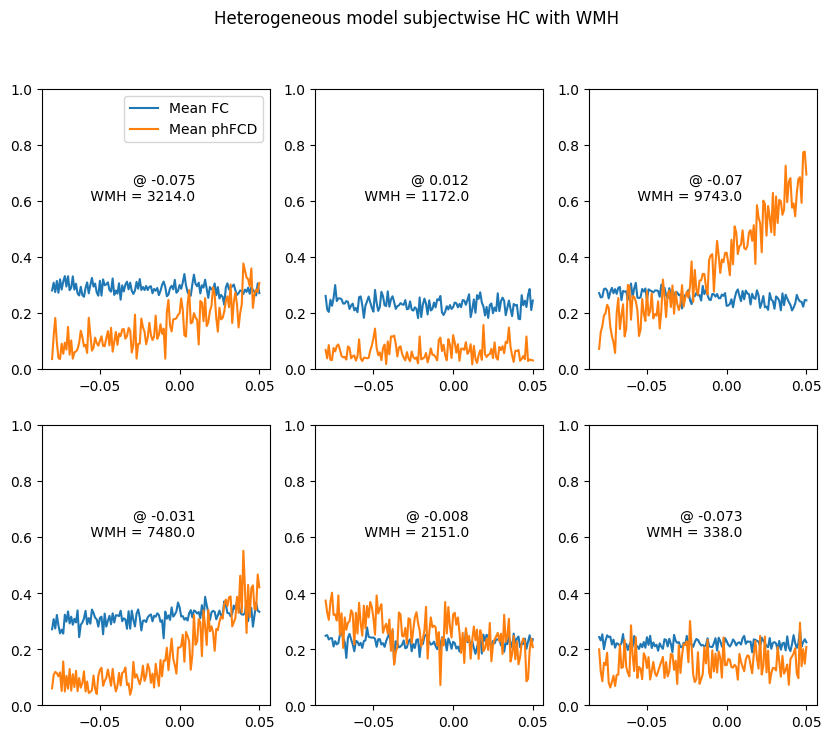

In [14]:
## Single subject plots HC homogeneous

idx_list1 = [0, 1, 2]
values_idx1 = [0, 1, 2]

idx_list2 = [0, 1, 2]
values_idx2 = [3, 4, 5]

plot_zip1 = zip(idx_list1, values_idx1)
plot_zip2 = zip(idx_list2, values_idx2)

fig, axis = plt.subplots(2, 3, figsize = (10, 8))

for i, v in plot_zip1:
        axis[0][i].plot(hetero_wmWs, hetero_FC_HC_WMH[v], label = 'Mean FC')
        axis[0][i].plot(hetero_wmWs, hetero_phFCD_HC_WMH[v], label = 'Mean phFCD')
        axis[0][i].set_ylim(0,1)
        axis[0][i].text(.01, .7, f'@ {hetero_wmWs[hetero_phFCD_HC_WMH[v].argmin()]}\n WMH = {WMH_HC_with_WMH[v]}',
                horizontalalignment='right',
                verticalalignment='top')        
for i, v in plot_zip2:
        axis[1][i].plot(hetero_wmWs, hetero_FC_HC_WMH[v], label = 'Mean FC')
        axis[1][i].plot(hetero_wmWs, hetero_phFCD_HC_WMH[v], label = 'Mean phFCD')
        axis[1][i].set_ylim(0,1)
        axis[1][i].text(.01, .7, f'@ {hetero_wmWs[hetero_phFCD_HC_WMH[v].argmin()]}\n WMH = {WMH_HC_with_WMH[v]}',
                horizontalalignment='right',
                verticalalignment='top')        

fig.suptitle("Heterogeneous model subjectwise HC with WMH")
plt.savefig(base_dir + '/Plots/plot_results_heterogeneous_model_subjectwise_HCwithWMH.png')
axis[0][0].legend()

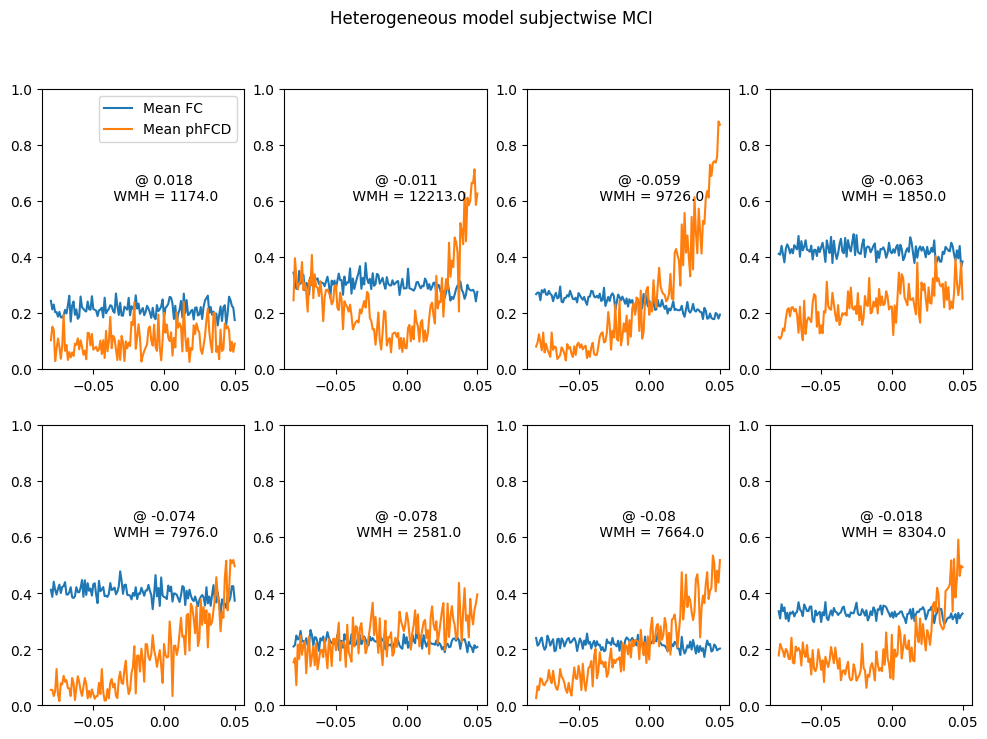

In [15]:
## Single subject plots MCI homogeneous

idx_list1 = [0, 1, 2, 3]
values_idx1 = [0, 1, 2, 3,]

idx_list2 = [0, 1, 2, 3]
values_idx2 = [4, 5, 6, 7]

plot_zip1 = zip(idx_list1, values_idx1)
plot_zip2 = zip(idx_list2, values_idx2)


fig, axis = plt.subplots(2, 4, figsize = (12, 8))

for i, v in plot_zip1:
        axis[0][i].plot(hetero_wmWs, hetero_FC_MCI_WMH[v], label = 'Mean FC')
        axis[0][i].plot(hetero_wmWs, hetero_phFCD_MCI_WMH[v], label = 'Mean phFCD')
        axis[0][i].set_ylim(0,1)
        axis[0][i].text(0, .7, f'@ {hetero_wmWs[hetero_phFCD_MCI_WMH[v].argmin()]}\n WMH = {WMH_MCI[v]}',
        horizontalalignment='center',
        verticalalignment='top')   

for i, v in plot_zip2:
        axis[1][i].plot(hetero_wmWs, hetero_FC_MCI_WMH[v], label = 'Mean FC')
        axis[1][i].plot(hetero_wmWs, hetero_phFCD_MCI_WMH[v], label = 'Mean phFCD')
        axis[1][i].set_ylim(0,1)
        axis[1][i].text(0, .7, f'@ {hetero_wmWs[hetero_phFCD_MCI_WMH[v].argmin()]}\n WMH = {WMH_MCI[v]}',
                        horizontalalignment='center',
                        verticalalignment='top')   


fig.suptitle("Heterogeneous model subjectwise MCI")
plt.savefig(base_dir + '/Plots/plot_results_heterogeneous_model_subjectwise_MCI_WMH.png')

axis[0][0].legend()

In [16]:
# randomgeneous model

# This is the same set of white matter hyperintensities weights that we used in the simulation. We need it to get the weights indices
random_wmWs = np.round(np.arange(-0.08,0.0501,0.001), 4)

# Get the FC and phFCD for each specific group
random_FC_HC, random_phFCD_HC, WMH_HC = get_FC_phFCD_heterogeneous_across_subjects(random_fitting_parms_dict_HC_noWMH)
random_FC_HC_WMH, random_phFCD_HC_WMH, WMH_HC_with_WMH = get_FC_phFCD_heterogeneous_across_subjects(random_fitting_parms_dict_HC_with_WMH)
random_FC_MCI_WMH, random_phFCD_MCI_WMH, WMH_MCI = get_FC_phFCD_heterogeneous_across_subjects(random_fitting_parms_dict_MCI_with_WMH)

# Calculate the means and 95% CI for FC and phFCD for each weight (supposing that there is a overall relation between WMH load and the bifurcation parameters)
random_FC_HC_mean = random_FC_HC.mean(axis = 0)
random_FC_HC_WMH_mean = random_FC_HC_WMH.mean(axis = 0)
random_FC_MCI_WMH_mean = random_FC_MCI_WMH.mean(axis = 0)

random_FC_HC_ci = 1.96 * np.std(random_FC_HC, axis = 0)/np.sqrt(len(random_wmWs))
random_FC_HC_WMH_ci = 1.96 * np.std(random_FC_HC_WMH, axis = 0)/np.sqrt(len(random_wmWs))
random_FC_MCI_WMH_ci = 1.96 * np.std(random_FC_MCI_WMH, axis = 0)/np.sqrt(len(random_wmWs))

random_phFCD_HC_mean = random_phFCD_HC.mean(axis = 0)
random_phFCD_HC_WMH_mean = random_phFCD_HC_WMH.mean(axis = 0)
random_phFCD_MCI_WMH_mean = random_phFCD_MCI_WMH.mean(axis = 0)

random_phFCD_HC_ci = 1.96 * np.std(random_phFCD_HC, axis = 0)/np.sqrt(len(random_wmWs))
random_phFCD_HC_WMH_ci = 1.96 * np.std(random_phFCD_HC_WMH, axis = 0)/np.sqrt(len(random_wmWs))
random_phFCD_MCI_WMH_ci = 1.96 * np.std(random_phFCD_MCI_WMH, axis = 0)/np.sqrt(len(random_wmWs))


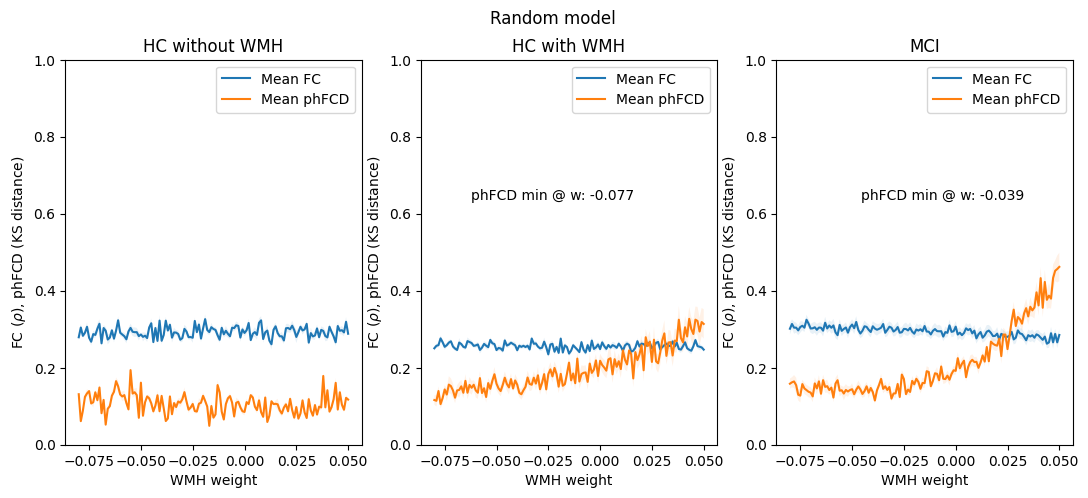

In [17]:

# Plot the results
figure, axis = plt.subplots(1, 3, figsize = (13,5))
axis[0].plot(random_wmWs, random_FC_HC_mean, label = 'Mean FC')
axis[0].fill_between(random_wmWs, (random_FC_HC_mean-random_FC_HC_ci), (random_FC_HC_mean+random_FC_HC_ci), alpha=.1) 
axis[0].plot(random_wmWs, random_phFCD_HC_mean, label = 'Mean phFCD') 
axis[0].fill_between(random_wmWs, (random_phFCD_HC_mean-random_phFCD_HC_ci), (random_phFCD_HC_mean+random_phFCD_HC_ci), alpha=.1)
axis[0].set_ylim(0,1) # same y limits for all
axis[0].legend()
axis[0].set_title('HC without WMH')

axis[1].plot(random_wmWs, random_FC_HC_WMH_mean, label = 'Mean FC')
axis[1].fill_between(random_wmWs, (random_FC_HC_WMH_mean-random_FC_HC_WMH_ci), (random_FC_HC_WMH_mean+random_FC_HC_WMH_ci), alpha=.1) # make the area between the upper CI and lower CI shaded.
axis[1].plot(random_wmWs, random_phFCD_HC_WMH_mean, label = 'Mean phFCD')
axis[1].fill_between(random_wmWs, (random_phFCD_HC_WMH_mean-random_phFCD_HC_WMH_ci), (random_phFCD_HC_WMH_mean+random_phFCD_HC_WMH_ci), alpha=.1)
axis[1].set_ylim(0,1)
axis[1].legend()
axis[1].set_title('HC with WMH')

axis[2].plot(random_wmWs, random_FC_MCI_WMH_mean, label = 'Mean FC')
axis[2].fill_between(random_wmWs, (random_FC_MCI_WMH_mean-random_FC_MCI_WMH_ci), (random_FC_MCI_WMH_mean+random_FC_MCI_WMH_ci), alpha=.1)
axis[2].plot(random_wmWs, random_phFCD_MCI_WMH_mean, label = 'Mean phFCD')
axis[2].fill_between(random_wmWs, (random_phFCD_MCI_WMH_mean-random_phFCD_MCI_WMH_ci), (random_phFCD_MCI_WMH_mean+random_phFCD_MCI_WMH_ci), alpha=.1)
axis[2].set_ylim(0,1)
axis[2].legend()
axis[2].set_title('MCI')

axis[0].set_xlabel('WMH weight')
axis[1].set_xlabel('WMH weight')
axis[2].set_xlabel('WMH weight')

axis[0].set_ylabel(r'FC ($\rho$), phFCD (KS distance)')
axis[1].set_ylabel(r'FC ($\rho$), phFCD (KS distance)')
axis[2].set_ylabel(r'FC ($\rho$), phFCD (KS distance)')

txt_HC_WMH=f'phFCD min @ w: {random_wmWs[random_phFCD_HC_WMH_mean.argmin()]}' # adds an explanatory note
plt.figtext(0.5, 0.6, txt_HC_WMH, wrap= True, horizontalalignment='center', fontsize=10)

txt_MCI=f'phFCD min @ w: {random_wmWs[random_phFCD_MCI_WMH_mean.argmin()]}' # adds an explanatory note
plt.figtext(0.8, 0.6, txt_MCI, wrap= True, horizontalalignment='center', fontsize=10)


figure.suptitle("Random model")

# Save figure
plt.savefig(base_dir + '/Plots/plot_results_random_model.png')

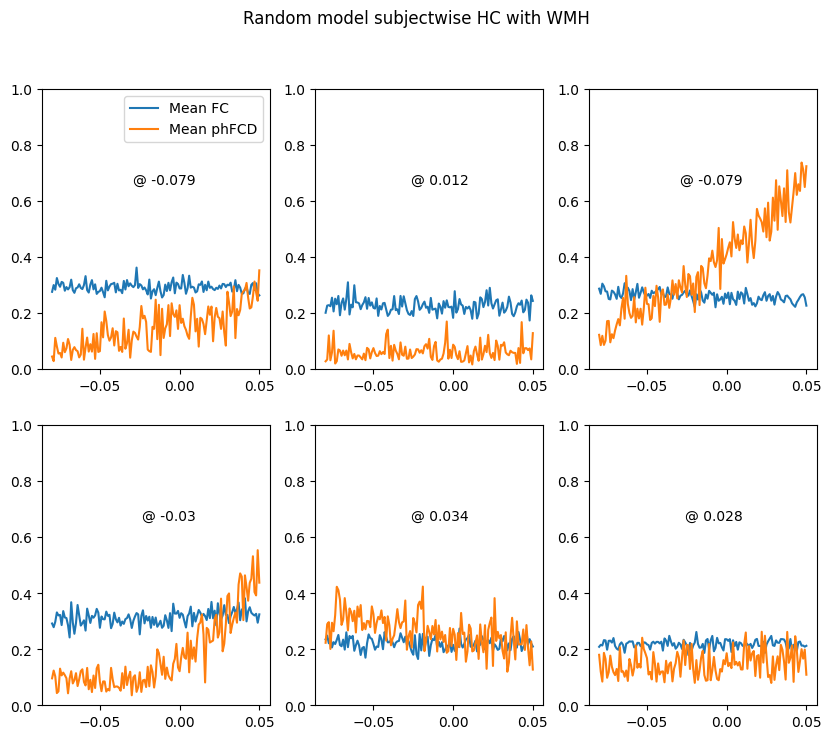

In [18]:
## Single subject plots HC homogeneous

idx_list1 = [0, 1, 2]
values_idx1 = [0, 1, 2]

idx_list2 = [0, 1, 2]
values_idx2 = [3, 4, 5]

plot_zip1 = zip(idx_list1, values_idx1)
plot_zip2 = zip(idx_list2, values_idx2)

fig, axis = plt.subplots(2, 3, figsize = (10, 8))

for i, v in plot_zip1:
        axis[0][i].plot(random_wmWs, random_FC_HC_WMH[v], label = 'Mean FC')
        axis[0][i].plot(random_wmWs, random_phFCD_HC_WMH[v], label = 'Mean phFCD')
        axis[0][i].set_ylim(0,1)
        axis[0][i].text(.01, .7, f'@ {random_wmWs[random_phFCD_HC_WMH[v].argmin()]}',
                horizontalalignment='right',
                verticalalignment='top')        
for i, v in plot_zip2:
        axis[1][i].plot(random_wmWs, random_FC_HC_WMH[v], label = 'Mean FC')
        axis[1][i].plot(random_wmWs, random_phFCD_HC_WMH[v], label = 'Mean phFCD')
        axis[1][i].set_ylim(0,1)
        axis[1][i].text(.01, .7, f'@ {random_wmWs[random_phFCD_HC_WMH[v].argmin()]}',
                horizontalalignment='right',
                verticalalignment='top')        

fig.suptitle("Random model subjectwise HC with WMH")
plt.savefig(base_dir + '/Plots/plot_results_random_model_subjectwise_HCwithWMH.png')
axis[0][0].legend()

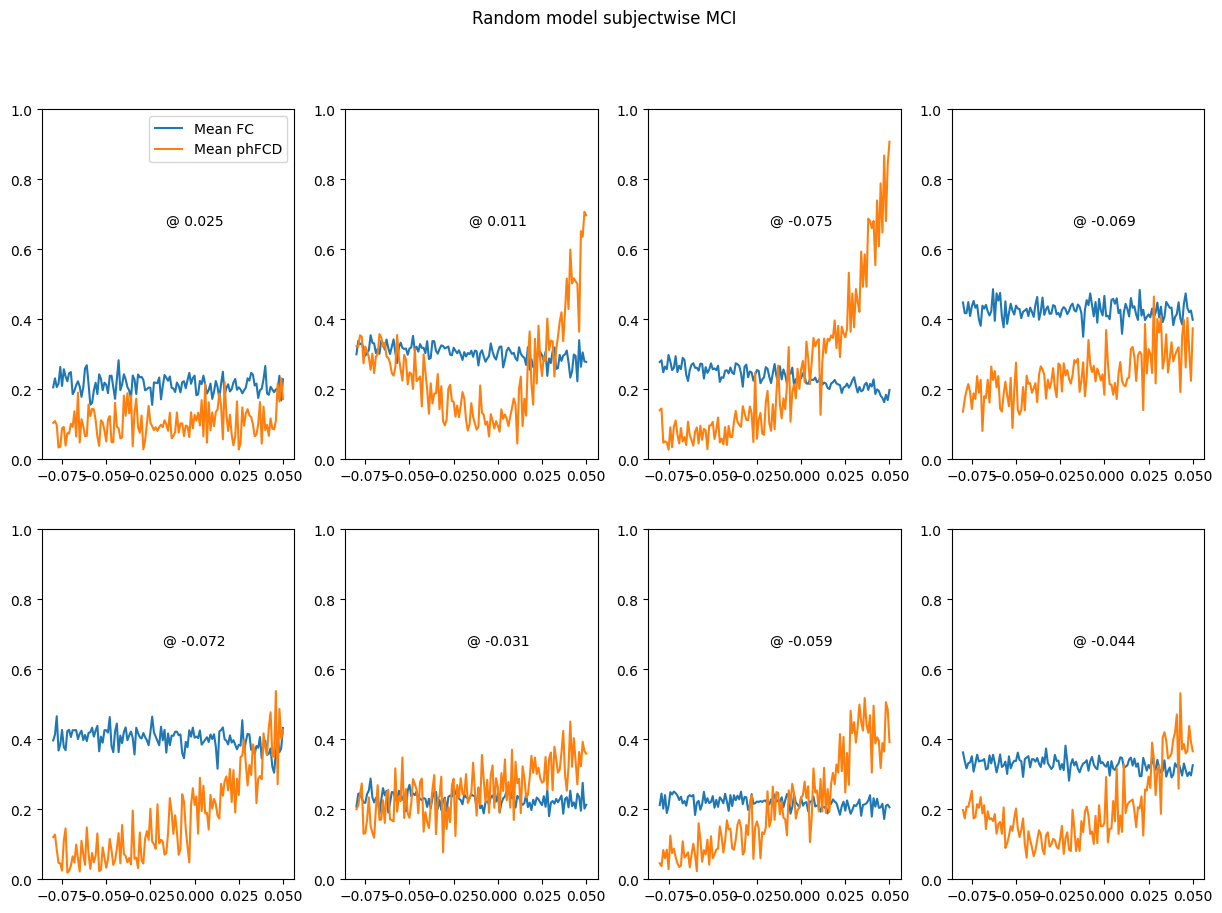

In [19]:
## Single subject plots MCI homogeneous

idx_list1 = [0, 1, 2, 3,]
values_idx1 = [0, 1, 2, 3]

idx_list2 = [0, 1, 2, 3]
values_idx2 = [4, 5, 6, 7, 8]

plot_zip1 = zip(idx_list1, values_idx1)
plot_zip2 = zip(idx_list2, values_idx2)


fig, axis = plt.subplots(2, 4, figsize = (15, 10))

for i, v in plot_zip1:
        axis[0][i].plot(random_wmWs, random_FC_MCI_WMH[v], label = 'Mean FC')
        axis[0][i].plot(random_wmWs, random_phFCD_MCI_WMH[v], label = 'Mean phFCD')
        axis[0][i].set_ylim(0,1)
        axis[0][i].text(0, .7, f'@ {random_wmWs[random_phFCD_MCI_WMH[v].argmin()]}',
        horizontalalignment='center',
        verticalalignment='top')   

for i, v in plot_zip2:
        axis[1][i].plot(random_wmWs, random_FC_MCI_WMH[v], label = 'Mean FC')
        axis[1][i].plot(random_wmWs, random_phFCD_MCI_WMH[v], label = 'Mean phFCD')
        axis[1][i].set_ylim(0,1)
        axis[1][i].text(0, .7, f'@ {random_wmWs[random_phFCD_MCI_WMH[v].argmin()]}',
                        horizontalalignment='center',
                        verticalalignment='top')   


fig.suptitle("Random model subjectwise MCI")
plt.savefig(base_dir + '/Plots/plot_results_random_model_subjectwise_MCI_withWMH.png')

axis[0][0].legend()

In [20]:

# # This is the same set of white matter hyperintensities weights that we used in the simulation. We need it to get the weights indices
# wmWs = np.round(np.arange(-0.2,0.05,0.005), 4)

# # Get the FC and phFCD for each specific group
# FC_MCI, phFCD_MCI = get_FC_phFCD_heterogeneous_across_subjects(more_hetero_fitting_parms_dict_MCI)

# # Calculate the means and 95% CI for FC and phFCD for each weight (supposing that there is a overall relation between WMH load and the bifurcation parameters)
# FC_MCI_mean = FC_MCI.mean(axis = 0)
# FC_MCI_ci = 1.96 * np.std(FC_MCI, axis = 0)/np.sqrt(len(wmWs))
# phFCD_MCI_mean = phFCD_MCI.mean(axis = 0)
# phFCD_MCI_ci = 1.96 * np.std(phFCD_MCI, axis = 0)/np.sqrt(len(wmWs))


# # Plot the results
# figure, axis = plt.subplots(1, 1, figsize = (5,4))
# axis.plot(wmWs, FC_MCI_mean, label = 'Mean FC')
# axis.fill_between(wmWs, (FC_MCI_mean-FC_MCI_ci), (FC_MCI_mean+FC_MCI_ci), alpha=.1)
# axis.plot(wmWs, phFCD_MCI_mean, label = 'Mean phFCD')
# axis.fill_between(wmWs, (phFCD_MCI_mean-phFCD_MCI_ci), (phFCD_MCI_mean+phFCD_MCI_ci), alpha=.1)
# axis.set_ylim(0,1)
# axis.legend()
# axis.set_title('MCI')

# axis.set_xlabel('WMH weight')
# axis.set_ylabel(r'FC ($\rho$), phFCD (KS distance)')

# # Save figure
# plt.savefig('/home/riccardo/ADNI_Hopf/Results/G_fitted_to_HC-minimalWMH/plot_results_fitting_with_more_negative_different_WMweights.png')


In [21]:
best_FC_a_fixed_HC_with_WMH, best_phFCD_a_fixed_HC_with_WMH = get_best_FC_phFCD(base_best_parms_HC_with_WMH)
best_FC_a_fixed_MCI, best_phFCD_a_fixed_MCI = get_best_FC_phFCD(base_best_parms_MCI)

best_FC_homogeneous_HC_with_WMH, best_phFCD_homogeneous_HC_with_WMH = get_best_FC_idx_best_phFCD(homo_best_parms_dict_HC_with_WMH, homo_fitting_parms_dict_HC_with_WMH)
best_FC_homogeneous_MCI, best_phFCD_homogeneous_MCI = get_best_FC_idx_best_phFCD(homo_best_parms_dict_MCI, homo_fitting_parms_dict_MCI)

best_FC_heterogeneous_HC_with_WMH, best_phFCD_heterogeneous_HC_with_WMH = get_best_FC_idx_best_phFCD(hetero_best_parms_dict_HC_with_WMH, hetero_fitting_parms_dict_HC_with_WMH)
best_FC_heterogeneous_MCI, best_phFCD_heterogeneous_MCI = get_best_FC_idx_best_phFCD(hetero_best_parms_dict_MCI, hetero_fitting_parms_dict_MCI)

best_FC_random_HC_with_WMH, best_phFCD_random_HC_with_WMH = get_best_FC_idx_best_phFCD(random_best_parms_dict_HC_with_WMH, random_fitting_parms_dict_HC_with_WMH)
best_FC_random_MCI, best_phFCD_random_MCI = get_best_FC_idx_best_phFCD(random_best_parms_dict_MCI, random_fitting_parms_dict_MCI)

In [22]:
wm_weighted_homo_best_FC_HC_WMH = []
wm_weighted_homo_best_phFCD_HC_WMH = []

for sub in homo_FC_HC_WMH:
    wm_weighted_homo_best_FC_HC_WMH.append(sub[homo_phFCD_HC_WMH_mean.argmin()])
for sub in homo_phFCD_HC_WMH:
    wm_weighted_homo_best_phFCD_HC_WMH.append(sub[homo_phFCD_HC_WMH_mean.argmin()])


wm_weighted_hetero_best_FC_HC_WMH = []
wm_weighted_hetero_best_phFCD_HC_WMH = []

for sub in hetero_FC_HC_WMH:
    wm_weighted_hetero_best_FC_HC_WMH.append(sub[hetero_phFCD_HC_WMH_mean.argmin()])
for sub in hetero_phFCD_HC_WMH:
    wm_weighted_hetero_best_phFCD_HC_WMH.append(sub[hetero_phFCD_HC_WMH_mean.argmin()])


wm_weighted_random_best_FC_HC_WMH = []
wm_weighted_random_best_phFCD_HC_WMH = []

for sub in random_FC_HC_WMH:
    wm_weighted_random_best_FC_HC_WMH.append(sub[random_phFCD_HC_WMH_mean.argmin()])
for sub in random_phFCD_HC_WMH:
    wm_weighted_random_best_phFCD_HC_WMH.append(sub[random_phFCD_HC_WMH_mean.argmin()])

In [23]:
wm_weighted_homo_best_FC_MCI_WMH = []
wm_weighted_homo_best_phFCD_MCI_WMH = []

for sub in homo_FC_MCI_WMH:
    wm_weighted_homo_best_FC_MCI_WMH.append(sub[homo_phFCD_MCI_WMH_mean.argmin()])
for sub in homo_phFCD_MCI_WMH:
    wm_weighted_homo_best_phFCD_MCI_WMH.append(sub[homo_phFCD_MCI_WMH_mean.argmin()])


wm_weighted_hetero_best_FC_MCI_WMH = []
wm_weighted_hetero_best_phFCD_MCI_WMH = []

for sub in hetero_FC_MCI_WMH:
    wm_weighted_hetero_best_FC_MCI_WMH.append(sub[hetero_phFCD_MCI_WMH_mean.argmin()])
for sub in hetero_phFCD_MCI_WMH:
    wm_weighted_hetero_best_phFCD_MCI_WMH.append(sub[hetero_phFCD_MCI_WMH_mean.argmin()])


wm_weighted_random_best_FC_MCI_WMH = []
wm_weighted_random_best_phFCD_MCI_WMH = []

for sub in random_FC_MCI_WMH:
    wm_weighted_random_best_FC_MCI_WMH.append(sub[random_phFCD_MCI_WMH_mean.argmin()])
for sub in random_phFCD_MCI_WMH:
    wm_weighted_random_best_phFCD_MCI_WMH.append(sub[random_phFCD_MCI_WMH_mean.argmin()])

In [24]:
import pingouin as pg

# Calculate ANOVA repeated measures for FC in HC with WMH
wm_weighted_df_FC_HC_with_WMH = pd.DataFrame({'model1': best_FC_a_fixed_HC_with_WMH, ' model2': wm_weighted_homo_best_FC_HC_WMH})
wm_weighted_RM_anova_FC_HC_with_WMH = pg.rm_anova(wm_weighted_df_FC_HC_with_WMH)

# Calculate ANOVA repeated measures for phFCD in HC with WMH
wm_weighted_df_phFCD_HC_with_WMH = pd.DataFrame({'model1': best_phFCD_a_fixed_HC_with_WMH, ' model2': wm_weighted_homo_best_phFCD_HC_WMH})
wm_weighted_RM_anova_phFCD_HC_with_WMH = pg.rm_anova(wm_weighted_df_phFCD_HC_with_WMH)


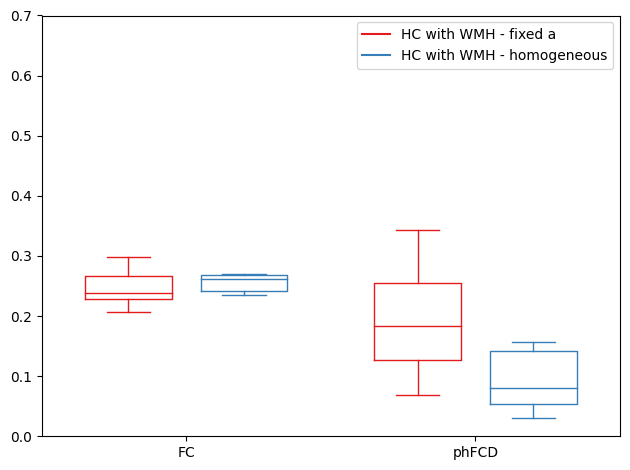

In [25]:
base_boxplot = [best_FC_a_fixed_HC_with_WMH, best_phFCD_a_fixed_HC_with_WMH]
homo_boxplot = [wm_weighted_homo_best_FC_HC_WMH, wm_weighted_homo_best_phFCD_HC_WMH]

ticks = ['FC', 'phFCD']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

base = plt.boxplot(base_boxplot, positions=np.array(range(len(base_boxplot)))*2.0-0.4, sym='', widths=0.6)
homo = plt.boxplot(homo_boxplot, positions=np.array(range(len(homo_boxplot)))*2.0+0.4, sym='', widths=0.6)
set_box_color(base, '#e41a1c') # colors are from http://colorbrewer2.org/
set_box_color(homo, '#377eb8')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#e41a1c', label='HC with WMH - fixed a')
plt.plot([], c='#377eb8', label='HC with WMH - homogeneous')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-1,len(ticks)*1.5)
plt.ylim(0, 0.7)
plt.tight_layout()
plt.savefig('boxcompare.png')

In [26]:
# Calculate the Wilcox. rank sum between the fixed a model and the random model and p-value for the HC group
MCI_stat_FC_aFixed_vs_homo, MCI_p_FC_aFixed_vs_homo = stats.mannwhitneyu(base_FC_MCI_noWMH, wm_weighted_homo_best_FC_MCI_WMH)
MCI_stat_phFCD_aFixed_vs_homo, MCI_p_phFCD_aFixed_vs_homo = stats.mannwhitneyu(base_phFCD_MCI_noWMH, wm_weighted_homo_best_phFCD_MCI_WMH)
# Calculate the min and max value between between the fixed a model and the random model for the HC group for visualization purposes both for FC and phFCD
MCI_max_FC_aFixed_vs_homo = np.max(np.concatenate((base_FC_MCI_noWMH, wm_weighted_homo_best_FC_MCI_WMH)))
MCI_min_FC_aFixed_vs_homo = np.min(np.concatenate((base_FC_MCI_noWMH, wm_weighted_homo_best_FC_MCI_WMH)))
MCI_max_phFCD_aFixed_vs_homo = np.max(np.concatenate((base_phFCD_MCI_noWMH, wm_weighted_homo_best_phFCD_MCI_WMH)))
MCI_min_phFCD_aFixed_vs_homo = np.min(np.concatenate((base_phFCD_MCI_noWMH, wm_weighted_homo_best_phFCD_MCI_WMH)))


In [27]:
WMH_normalized_all_file = open('/home/riccardo/ADNI_Hopf/Results/overall_WMH_burden_all_normalized.pkl', 'rb')
WMH_normalized_all = pickle.load(WMH_normalized_all_file)

arr_WMH_MCI_withWMH = np.array([v for k,v in WMH_normalized_all.items() if k in MCI_WMH])
a_values_MCI_withWMH = -0.02 + homo_wmWs[homo_phFCD_MCI_WMH_mean.argmin()] * arr_WMH_MCI_withWMH


arr_WMH_HC_withWMH = np.array([v for k,v in WMH_normalized_all.items() if k in HC_WMH])
a_values_HC_withWMH = -0.02 + homo_wmWs[homo_phFCD_HC_WMH_mean.argmin()] * arr_WMH_HC_withWMH

In [28]:
temp_MCI = {}
temp_HC = {}
for k,v in WMH_normalized_all.items():
    if k in MCI_WMH:
        sub_dict = {'WMH': v, 'a': -0.02 + homo_wmWs[homo_phFCD_MCI_WMH_mean.argmin()] * v}
        temp_MCI[k] = sub_dict
    if k in HC_WMH:
        sub_dict = {'WMH': v, 'a': -0.02 + homo_wmWs[homo_phFCD_HC_WMH_mean.argmin()] * v}
        temp_HC[k] = sub_dict

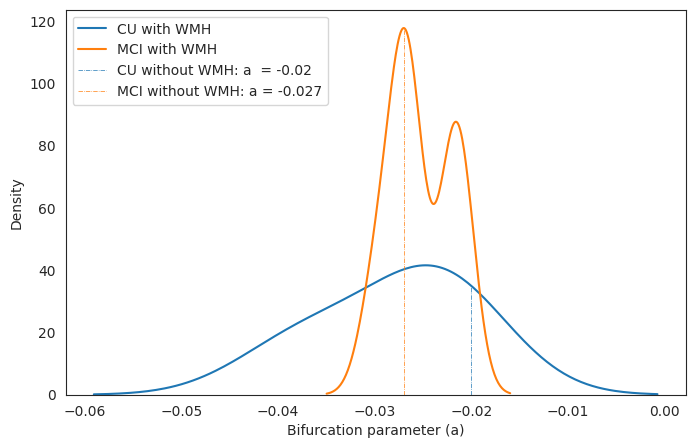

In [30]:
plt.figure(figsize=(8,5))
sns.set_style('white')
sns.kdeplot(np.array(a_values_HC_withWMH), bw_method=.9, label = 'CU with WMH');
sns.kdeplot(np.array(a_values_MCI_withWMH), bw_method=.5, label = 'MCI with WMH');
plt.plot(np.repeat(-0.02, 10), np.linspace(0,35,10), '-.', color = 'tab:blue', linewidth = .5, label = 'CU without WMH: a  = -0.02')
plt.plot(np.repeat(-0.027, 10), np.linspace(0,117,10), '-.', color = 'tab:orange', linewidth = .5, label = 'MCI without WMH: a = -0.027')

# Add the legend manually to the current Axes.
plt.legend(loc = 2)
plt.xlabel('Bifurcation parameter (a)')
plt.savefig(base_dir + '/Plots/plot_a_distribution_both_groups.png')

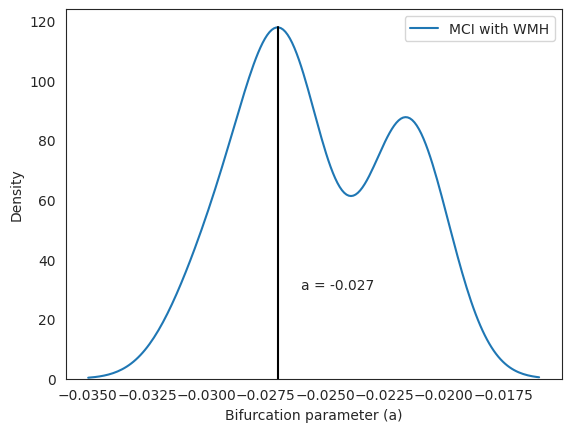

In [31]:
import seaborn as sns
sns.set_style('white')
sns.kdeplot(np.array(a_values_MCI_withWMH), bw_method=.5, label = 'MCI with WMH');
plt.plot(np.repeat(-0.027, 10), np.linspace(0,118,10), '-k')
plt.xlabel('Bifurcation parameter (a)')
text = 'a = -0.027'
plt.text(-0.026, 30, text)
plt.legend()
plt.savefig(base_dir + '/Plots/plot_a_distribution_MCI_with_WMH.png')

In [32]:
HC_p_FC_aFixed_vs_homo = wm_weighted_RM_anova_FC_HC_with_WMH['p-unc'][0]
HC_p_phFCD_aFixed_vs_homo = wm_weighted_RM_anova_phFCD_HC_with_WMH['p-unc'][0]

In [33]:
print(f'base FC median {np.quantile(best_FC_a_fixed_HC_with_WMH, 0.5)}')
print(f'base FC first quartile {np.quantile(best_FC_a_fixed_HC_with_WMH, 0.25)}')
print(f'base FC third quartile {np.quantile(best_FC_a_fixed_HC_with_WMH, 0.75)}')

print(f'Homo FC median {np.quantile(wm_weighted_homo_best_FC_HC_WMH, 0.5)}')
print(f'Homo FC first quartile {np.quantile(wm_weighted_homo_best_FC_HC_WMH, 0.25)}')
print(f'Homo FC third quartile {np.quantile(wm_weighted_homo_best_FC_HC_WMH, 0.75)}')

base FC median 0.23915355568576835
base FC first quartile 0.2283268684341181
base FC third quartile 0.2661221569188025
Homo FC median 0.2613125667364442
Homo FC first quartile 0.24225956507472224
Homo FC third quartile 0.2681577689755954


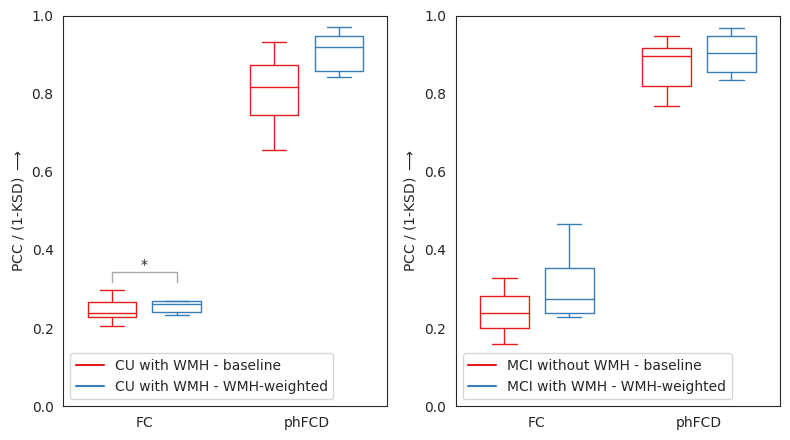

In [40]:
base_boxplot_HC = [best_FC_a_fixed_HC_with_WMH, 1 - np.array(best_phFCD_a_fixed_HC_with_WMH)]
homo_boxplot_HC = [wm_weighted_homo_best_FC_HC_WMH, 1 - np.array(wm_weighted_homo_best_phFCD_HC_WMH)]

base_boxplot_MCI = [base_FC_MCI_noWMH, 1- np.array(base_phFCD_MCI_noWMH)]
homo_boxplot_MCI = [wm_weighted_homo_best_FC_MCI_WMH, 1 - np.array(wm_weighted_homo_best_phFCD_MCI_WMH)]


ticks = ['FC', 'phFCD']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

fig, axis = plt.subplots(1,2, figsize = (8,4.5))

base = axis[0].boxplot(base_boxplot_HC, positions=np.array(range(len(base_boxplot)))*2.0-0.4, sym='', widths=0.6)
homo = axis[0].boxplot(homo_boxplot_HC, positions=np.array(range(len(homo_boxplot)))*2.0+0.4, sym='', widths=0.6)
set_box_color(base, '#e41a1c') # colors are from http://colorbrewer2.org/
set_box_color(homo, '#377eb8')

base = axis[1].boxplot(base_boxplot_MCI, positions=np.array(range(len(base_boxplot)))*2.0-0.4, sym='', widths=0.6)
homo = axis[1].boxplot(homo_boxplot_MCI, positions=np.array(range(len(homo_boxplot)))*2.0+0.4, sym='', widths=0.6)
set_box_color(base, '#e41a1c') # colors are from http://colorbrewer2.org/
set_box_color(homo, '#377eb8')


# # draw temporary red and blue lines and use them to create a legend
axis[0].plot([], c='#e41a1c', label='CU with WMH - baseline')
axis[0].plot([], c='#377eb8', label='CU with WMH - WMH-weighted')
axis[0].legend()


# draw temporary red and blue lines and use them to create a legend
axis[1].plot([], c='#e41a1c', label='MCI without WMH - baseline')
axis[1].plot([], c='#377eb8', label='MCI with WMH - WMH-weighted')
axis[1].legend()


# # Make annotations for p-values
axis[0].annotate("", xy=(-0.4, 0.31), xycoords='data',
           xytext=(0.4, 0.31), textcoords='data',
           arrowprops=dict(arrowstyle='-', ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
axis[0].text(0, 0.38, f'*',
       horizontalalignment='center',
       verticalalignment='top')
# 
# axis[0].annotate("", xy=(1.6, 0.35), xycoords='data',
#            xytext=(2.4, 0.35), textcoords='data',
#            arrowprops=dict(arrowstyle='-', ec='#aaaaaa',
#                            connectionstyle="bar,fraction=0.2"))
# axis[0].text(2, 0.41, f'p = {round(HC_p_phFCD_aFixed_vs_homo, 3)}',
#        horizontalalignment='center',
#        verticalalignment='top')


# axis[1].annotate("", xy=(-0.4, 0.48), xycoords='data',
#            xytext=(0.4, 0.48), textcoords='data',
#            arrowprops=dict(arrowstyle='-', ec='#aaaaaa',
#                            connectionstyle="bar,fraction=0.2"))
# axis[1].text(0, 0.55, f'p = {round(MCI_p_FC_aFixed_vs_homo, 3)}',
#        horizontalalignment='center',
#        verticalalignment='top')

# axis[1].annotate("", xy=(1.6, 0.25), xycoords='data',
#            xytext=(2.4, 0.25), textcoords='data',
#            arrowprops=dict(arrowstyle='-', ec='#aaaaaa',
#                            connectionstyle="bar,fraction=0.2"))
# axis[1].text(2, 0.31, f'p = {round(MCI_p_phFCD_aFixed_vs_homo, 3)}',
#        horizontalalignment='center',
#        verticalalignment='top')




axis[0].set_xticks(range(0, len(ticks) * 2, 2), ticks)
axis[0].set_xlim(-1,len(ticks)*1.5)
axis[0].set_ylim(0, 1)
axis[0].set_ylabel(r'PCC / (1-KSD) $\longrightarrow$')
axis[1].set_xticks(range(0, len(ticks) * 2, 2), ticks)
axis[1].set_xlim(-1,len(ticks)*1.5)
axis[1].set_ylim(0, 1)
axis[1].set_ylabel(r'PCC / (1-KSD) $\longrightarrow$')
# axis[1].annotate("", xy=(-2, 0.2 + 0.05), xycoords='data',
#         xytext=(-1, 0.4 + 0.05), textcoords='data',
#         arrowprops=dict(arrowstyle="<-", ec='#aaaaaa', color = 'black'))
plt.tight_layout()
plt.savefig(base_dir + 'Plots/plot_boxcompare_FC_phFCD_CNWith_WMH_MCI.png')

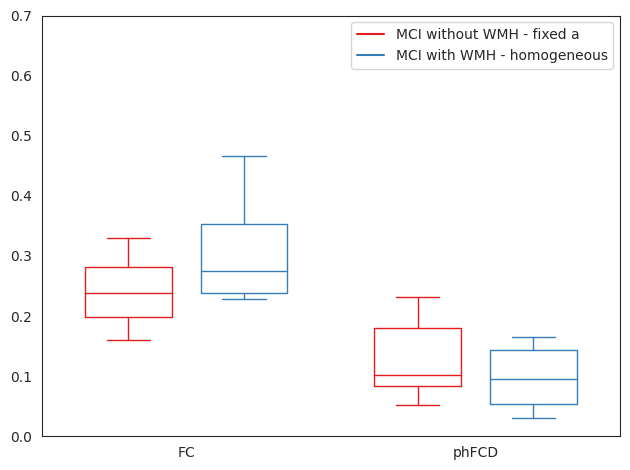

In [35]:
base_boxplot = [base_FC_MCI_noWMH, base_phFCD_MCI_noWMH]
homo_boxplot = [wm_weighted_homo_best_FC_MCI_WMH, wm_weighted_homo_best_phFCD_MCI_WMH]

ticks = ['FC', 'phFCD']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

base = plt.boxplot(base_boxplot, positions=np.array(range(len(base_boxplot)))*2.0-0.4, sym='', widths=0.6)
homo = plt.boxplot(homo_boxplot, positions=np.array(range(len(homo_boxplot)))*2.0+0.4, sym='', widths=0.6)
set_box_color(base, '#e41a1c') # colors are from http://colorbrewer2.org/
set_box_color(homo, '#377eb8')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#e41a1c', label='MCI without WMH - fixed a')
plt.plot([], c='#377eb8', label='MCI with WMH - homogeneous')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-1,len(ticks)*1.5)
plt.ylim(0, 0.7)
plt.tight_layout()
plt.savefig('boxcompare.png')


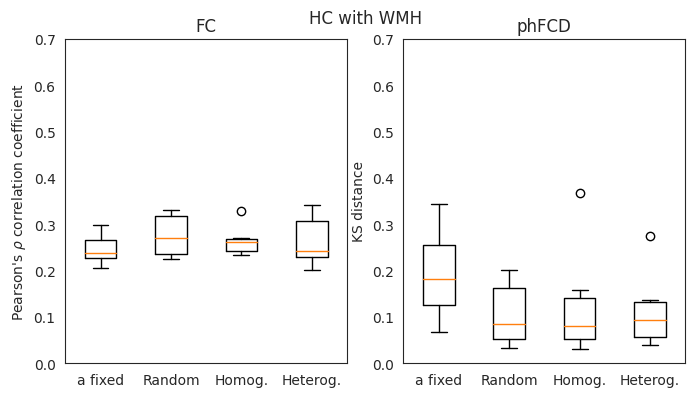

In [36]:
fig, axs = plt.subplots(1,2, figsize=(8, 3))

x_ticks = [1, 2, 3, 4]

axs[0].boxplot([best_FC_a_fixed_HC_with_WMH, wm_weighted_random_best_FC_HC_WMH, wm_weighted_homo_best_FC_HC_WMH, wm_weighted_hetero_best_FC_HC_WMH]);
axs[0].set_xticks(x_ticks);
axs[0].set_xticklabels(['a fixed', 'Random', 'Homog.', 'Heterog.']);

axs[0].set_ylim(0, .7)
axs[0].set_ylabel(r"Pearson's $\rho$ correlation coefficient")
axs[0].set_title('FC')
# axs[0].annotate("", xy=(1, HC_max_FC_aFixed_vs_random), xycoords='data',
#            xytext=(2, HC_max_FC_aFixed_vs_random), textcoords='data',
#            arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                            connectionstyle="bar,fraction=0.2"))
# axs[0].text(1.5, HC_max_FC_aFixed_vs_random + abs(HC_max_FC_aFixed_vs_random - HC_min_FC_aFixed_vs_random)*0.5, stars(HC_p_FC_aFixed_vs_random),
#        horizontalalignment='center',
#        verticalalignment='bottom')

# axs[0].annotate("", xy=(2, HC_max_FC_homo_vs_random + 0.05), xycoords='data',
#            xytext=(3, HC_max_FC_homo_vs_random + 0.05), textcoords='data',
#            arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                            connectionstyle="bar,fraction=0.2"))
# axs[0].text(2.5, HC_max_FC_homo_vs_random + 0.05 + abs(HC_max_FC_homo_vs_random - HC_min_FC_homo_vs_random)*0.4, stars(HC_p_FC_homo_vs_random),
#        horizontalalignment='center',
#        verticalalignment='bottom')

# axs[0].annotate("", xy=(1, HC_max_FC_aFixed_vs_homo + 0.1), xycoords='data',
#         xytext=(3, HC_max_FC_aFixed_vs_homo + 0.1), textcoords='data',
#         arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                         connectionstyle="bar,fraction=0.2"))
# axs[0].text(2, HC_max_FC_aFixed_vs_homo + abs(HC_max_FC_aFixed_vs_homo - HC_min_FC_aFixed_vs_homo)*1, stars(HC_p_FC_aFixed_vs_homo),
#     horizontalalignment='center',
#     verticalalignment='bottom')

# axs[0].annotate("", xy=(3, HC_max_FC_hetero_vs_homo + 0.2), xycoords='data',
#         xytext=(4, HC_max_FC_hetero_vs_homo + 0.2), textcoords='data',
#         arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                         connectionstyle="bar,fraction=0.2"))
# axs[0].text(3.5, HC_max_FC_hetero_vs_homo + abs(HC_max_FC_hetero_vs_homo - HC_min_FC_hetero_vs_homo)*1.5, stars(HC_p_FC_hetero_vs_homo),
#     horizontalalignment='center',
#     verticalalignment='bottom')

axs[1].boxplot([best_phFCD_a_fixed_HC_with_WMH, wm_weighted_random_best_phFCD_HC_WMH, wm_weighted_homo_best_phFCD_HC_WMH, wm_weighted_hetero_best_phFCD_HC_WMH]);
axs[1].set_xticks(x_ticks);
axs[1].set_xticklabels(['a fixed', 'Random', 'Homog.', 'Heterog.']);
axs[1].set_ylim(0, .7)
axs[1].set_ylabel("KS distance")
axs[1].set_title('phFCD')
# axs[1].annotate("", xy=(1, HC_max_phFCD_aFixed_vs_random), xycoords='data',
#            xytext=(2, HC_max_phFCD_aFixed_vs_random), textcoords='data',
#            arrowprops=dict(arrowstyle='-', ec='#aaaaaa',
#                            connectionstyle="bar,fraction=0.2"))
# axs[1].text(1.5, HC_max_phFCD_aFixed_vs_random + abs(HC_max_phFCD_aFixed_vs_random - HC_min_phFCD_aFixed_vs_random)*0.18, stars(HC_p_phFCD_aFixed_vs_random),
#        horizontalalignment='center',
#        verticalalignment='top')

# axs[1].annotate("", xy=(2, HC_max_phFCD_homo_vs_random), xycoords='data',
#            xytext=(3, HC_max_phFCD_homo_vs_random), textcoords='data',
#            arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                            connectionstyle="bar,fraction=0.2"))
# axs[1].text(2.5, HC_max_phFCD_homo_vs_random + abs(HC_max_phFCD_homo_vs_random - HC_min_phFCD_homo_vs_random) * 0.78, stars(HC_p_phFCD_homo_vs_random),
#        horizontalalignment='center',
#        verticalalignment='top')

# axs[1].annotate("", xy=(1, HC_max_phFCD_aFixed_vs_homo + 0.05), xycoords='data',
#         xytext=(3, HC_max_phFCD_aFixed_vs_homo + 0.05), textcoords='data',
#         arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                         connectionstyle="bar,fraction=0.2"))
# axs[1].text(2, HC_max_phFCD_aFixed_vs_homo + abs(HC_max_phFCD_aFixed_vs_homo - HC_min_phFCD_aFixed_vs_homo)*0.38, stars(HC_p_phFCD_aFixed_vs_homo),
#     horizontalalignment='center',
#     verticalalignment='bottom')

# axs[1].annotate("", xy=(3, HC_max_phFCD_hetero_vs_homo + 0.10), xycoords='data',
#         xytext=(4, HC_max_phFCD_hetero_vs_homo + 0.10), textcoords='data',
#         arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                         connectionstyle="bar,fraction=0.2"))
# axs[1].text(3.5, HC_max_phFCD_hetero_vs_homo + abs(HC_max_phFCD_hetero_vs_homo - HC_min_phFCD_hetero_vs_homo)*2.35, stars(HC_p_phFCD_hetero_vs_homo),
#     horizontalalignment='center',
#     verticalalignment='bottom')


fig.subplots_adjust(bottom=-0.2)
fig.suptitle('HC with WMH')
plt.savefig(base_dir + '/Plots/wm_weighted_boxplot_model_performances_HC_with_WMH.png', bbox_inches = "tight")


In [37]:
wm_weighted_homo_best_FC_MCI = []
wm_weighted_homo_best_phFCD_MCI = []

for sub in homo_FC_MCI:
    wm_weighted_homo_best_FC_MCI.append(sub[homo_phFCD_MCI_mean.argmin()])
for sub in homo_phFCD_MCI:
    wm_weighted_homo_best_phFCD_MCI.append(sub[homo_phFCD_MCI_mean.argmin()])


wm_weighted_hetero_best_FC_MCI = []
wm_weighted_hetero_best_phFCD_MCI = []

for sub in hetero_FC_MCI:
    wm_weighted_hetero_best_FC_MCI.append(sub[hetero_phFCD_MCI_mean.argmin()])
for sub in hetero_phFCD_MCI:
    wm_weighted_hetero_best_phFCD_MCI.append(sub[hetero_phFCD_MCI_mean.argmin()])


wm_weighted_random_best_FC_MCI = []
wm_weighted_random_best_phFCD_MCI = []

for sub in random_FC_MCI:
    wm_weighted_random_best_FC_MCI.append(sub[random_phFCD_MCI_mean.argmin()])
for sub in random_phFCD_MCI:
    wm_weighted_random_best_phFCD_MCI.append(sub[random_phFCD_MCI_mean.argmin()])


NameError: name 'homo_FC_MCI' is not defined

In [ ]:
print('HC with WMH')
print('----------------------------------------------------')
print('-Baseline model:')
print(f'--Median (IQR) correlation coefficient: {round(np.quantile(best_FC_a_fixed_HC_with_WMH,.25), 3)} ({round(np.quantile(best_FC_a_fixed_HC_with_WMH,.5))}-{round(np.quantile(best_FC_a_fixed_HC_with_WMH,.75),3)})')
print(f'--Median (IQR) KS: {round(np.quantile(best_phFCD_a_fixed_HC_with_WMH,.25), 3)} ({round(np.quantile(best_phFCD_a_fixed_HC_with_WMH,.5))}-{round(np.quantile(best_phFCD_a_fixed_HC_with_WMH,.75),3)})') 
print('-Homogeneous model:')
print(f'--Median (IQR) correlation coefficient: {round(np.quantile(wm_weighted_homo_best_FC_HC_WMH,.25), 3)} ({round(np.quantile(wm_weighted_homo_best_FC_HC_WMH,.5))}-{round(np.quantile(wm_weighted_homo_best_FC_HC_WMH,.75),3)})')
print(f'--Median (IQR) KS: {round(np.quantile(wm_weighted_homo_best_phFCD_HC_WMH,.25), 3)} ({round(np.quantile(wm_weighted_homo_best_phFCD_HC_WMH,.5))}-{round(np.quantile(wm_weighted_homo_best_phFCD_HC_WMH,.75),3)})') 
print('-Heterogeneous model:')
print(f'--Median (IQR) correlation coefficient: {round(np.quantile(wm_weighted_hetero_best_FC_HC_WMH,.25), 3)} ({round(np.quantile(wm_weighted_hetero_best_FC_HC_WMH,.5))}-{round(np.quantile(wm_weighted_hetero_best_FC_HC_WMH,.75),3)})')
print(f'--Median (IQR) KS: {round(np.quantile(wm_weighted_hetero_best_phFCD_HC_WMH,.25), 3)} ({round(np.quantile(wm_weighted_hetero_best_phFCD_HC_WMH,.5))}-{round(np.quantile(wm_weighted_hetero_best_phFCD_HC_WMH,.75),3)})') 
print('-Random model:')
print(f'--Median (IQR) correlation coefficient: {round(np.quantile(wm_weighted_random_best_FC_HC_WMH,.25), 3)} ({round(np.quantile(wm_weighted_random_best_FC_HC_WMH,.5))}-{round(np.quantile(wm_weighted_random_best_FC_HC_WMH,.75),3)})')
print(f'--Median (IQR) KS: {round(np.quantile(wm_weighted_random_best_phFCD_HC_WMH,.25), 3)} ({round(np.quantile(wm_weighted_random_best_phFCD_HC_WMH,.5))}-{round(np.quantile(wm_weighted_random_best_phFCD_HC_WMH,.75),3)})') 
print('----------------------------------------------------')
print('MCI')
print('----------------------------------------------------')
print('-Baseline model:')
print(f'--Median (IQR) correlation coefficient: {round(np.quantile(best_FC_a_fixed_MCI,.25), 3)} ({round(np.quantile(best_FC_a_fixed_MCI,.5))}-{round(np.quantile(best_FC_a_fixed_MCI,.75),3)})')
print(f'--Median (IQR) KS: {round(np.quantile(best_phFCD_a_fixed_MCI,.25), 3)} ({round(np.quantile(best_phFCD_a_fixed_MCI,.5))}-{round(np.quantile(best_phFCD_a_fixed_MCI,.75),3)})') 
print('-Homogeneous model:')
print(f'--Median (IQR) correlation coefficient: {round(np.quantile(wm_weighted_homo_best_FC_MCI,.25), 3)} ({round(np.quantile(wm_weighted_homo_best_FC_MCI,.5))}-{round(np.quantile(wm_weighted_homo_best_FC_MCI,.75),3)})')
print(f'--Median (IQR) KS: {round(np.quantile(wm_weighted_homo_best_phFCD_MCI,.25), 3)} ({round(np.quantile(wm_weighted_homo_best_phFCD_MCI,.5))}-{round(np.quantile(wm_weighted_homo_best_phFCD_MCI,.75),3)})') 
print('-Heterogeneous model:')
print(f'--Median (IQR) correlation coefficient: {round(np.quantile(wm_weighted_hetero_best_FC_MCI,.25), 3)} ({round(np.quantile(wm_weighted_hetero_best_FC_MCI,.5))}-{round(np.quantile(wm_weighted_hetero_best_FC_MCI,.75),3)})')
print(f'--Median (IQR) KS: {round(np.quantile(wm_weighted_hetero_best_phFCD_MCI,.25), 3)} ({round(np.quantile(wm_weighted_hetero_best_phFCD_MCI,.5))}-{round(np.quantile(wm_weighted_hetero_best_phFCD_MCI,.75),3)})') 
print('-Random model:')
print(f'--Median (IQR) correlation coefficient: {round(np.quantile(wm_weighted_random_best_FC_MCI,.25), 3)} ({round(np.quantile(wm_weighted_random_best_FC_MCI,.5))}-{round(np.quantile(wm_weighted_random_best_FC_MCI,.75),3)})')
print(f'--Median (IQR) KS: {round(np.quantile(wm_weighted_random_best_phFCD_MCI,.25), 3)} ({round(np.quantile(wm_weighted_random_best_phFCD_MCI,.5))}-{round(np.quantile(wm_weighted_random_best_phFCD_MCI,.75),3)})') 

HC with WMH
----------------------------------------------------
-Baseline model:
--Median (IQR) correlation coefficient: 0.228 (0-0.266)
--Median (IQR) KS: 0.127 (0-0.255)
-Homogeneous model:
--Median (IQR) correlation coefficient: 0.242 (0-0.268)
--Median (IQR) KS: 0.053 (0-0.141)
-Heterogeneous model:
--Median (IQR) correlation coefficient: 0.229 (0-0.308)
--Median (IQR) KS: 0.057 (0-0.132)
-Random model:
--Median (IQR) correlation coefficient: 0.236 (0-0.319)
--Median (IQR) KS: 0.053 (0-0.162)
----------------------------------------------------
MCI
----------------------------------------------------
-Baseline model:
--Median (IQR) correlation coefficient: 0.216 (0-0.301)
--Median (IQR) KS: 0.125 (0-0.244)
-Homogeneous model:


NameError: name 'wm_weighted_homo_best_FC_MCI' is not defined

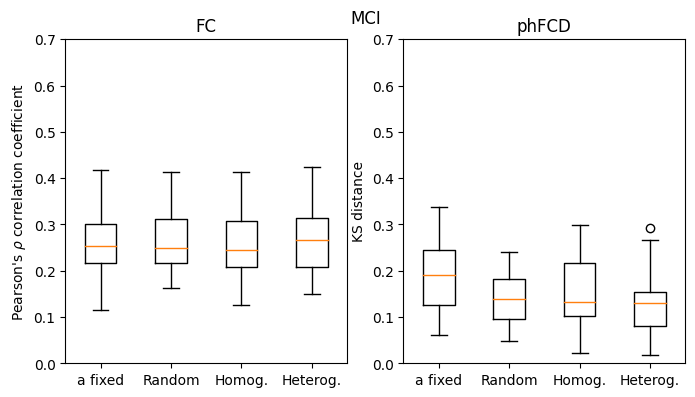

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8, 3))

x_ticks = [1, 2, 3, 4]

axs[0].boxplot([best_FC_a_fixed_MCI, wm_weighted_random_best_FC_MCI, wm_weighted_homo_best_FC_MCI, wm_weighted_hetero_best_FC_MCI]);
axs[0].set_xticks(x_ticks);
axs[0].set_xticklabels(['a fixed', 'Random', 'Homog.', 'Heterog.']);

axs[0].set_ylim(0, .7)
axs[0].set_ylabel(r"Pearson's $\rho$ correlation coefficient")
axs[0].set_title('FC')
# axs[0].annotate("", xy=(1, HC_max_FC_aFixed_vs_random), xycoords='data',
#            xytext=(2, HC_max_FC_aFixed_vs_random), textcoords='data',
#            arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                            connectionstyle="bar,fraction=0.2"))
# axs[0].text(1.5, HC_max_FC_aFixed_vs_random + abs(HC_max_FC_aFixed_vs_random - HC_min_FC_aFixed_vs_random)*0.5, stars(HC_p_FC_aFixed_vs_random),
#        horizontalalignment='center',
#        verticalalignment='bottom')

# axs[0].annotate("", xy=(2, HC_max_FC_homo_vs_random + 0.05), xycoords='data',
#            xytext=(3, HC_max_FC_homo_vs_random + 0.05), textcoords='data',
#            arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                            connectionstyle="bar,fraction=0.2"))
# axs[0].text(2.5, HC_max_FC_homo_vs_random + 0.05 + abs(HC_max_FC_homo_vs_random - HC_min_FC_homo_vs_random)*0.4, stars(HC_p_FC_homo_vs_random),
#        horizontalalignment='center',
#        verticalalignment='bottom')

# axs[0].annotate("", xy=(1, HC_max_FC_aFixed_vs_homo + 0.1), xycoords='data',
#         xytext=(3, HC_max_FC_aFixed_vs_homo + 0.1), textcoords='data',
#         arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                         connectionstyle="bar,fraction=0.2"))
# axs[0].text(2, HC_max_FC_aFixed_vs_homo + abs(HC_max_FC_aFixed_vs_homo - HC_min_FC_aFixed_vs_homo)*1, stars(HC_p_FC_aFixed_vs_homo),
#     horizontalalignment='center',
#     verticalalignment='bottom')

# axs[0].annotate("", xy=(3, HC_max_FC_hetero_vs_homo + 0.2), xycoords='data',
#         xytext=(4, HC_max_FC_hetero_vs_homo + 0.2), textcoords='data',
#         arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                         connectionstyle="bar,fraction=0.2"))
# axs[0].text(3.5, HC_max_FC_hetero_vs_homo + abs(HC_max_FC_hetero_vs_homo - HC_min_FC_hetero_vs_homo)*1.5, stars(HC_p_FC_hetero_vs_homo),
#     horizontalalignment='center',
#     verticalalignment='bottom')

axs[1].boxplot([best_phFCD_a_fixed_MCI, wm_weighted_random_best_phFCD_MCI, wm_weighted_homo_best_phFCD_MCI, wm_weighted_hetero_best_phFCD_MCI]);
axs[1].set_xticks(x_ticks);
axs[1].set_xticklabels(['a fixed', 'Random', 'Homog.', 'Heterog.']);
axs[1].set_ylim(0, .7)
axs[1].set_ylabel("KS distance")
axs[1].set_title('phFCD')
# axs[1].annotate("", xy=(1, HC_max_phFCD_aFixed_vs_random), xycoords='data',
#            xytext=(2, HC_max_phFCD_aFixed_vs_random), textcoords='data',
#            arrowprops=dict(arrowstyle='-', ec='#aaaaaa',
#                            connectionstyle="bar,fraction=0.2"))
# axs[1].text(1.5, HC_max_phFCD_aFixed_vs_random + abs(HC_max_phFCD_aFixed_vs_random - HC_min_phFCD_aFixed_vs_random)*0.18, stars(HC_p_phFCD_aFixed_vs_random),
#        horizontalalignment='center',
#        verticalalignment='top')

# axs[1].annotate("", xy=(2, HC_max_phFCD_homo_vs_random), xycoords='data',
#            xytext=(3, HC_max_phFCD_homo_vs_random), textcoords='data',
#            arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                            connectionstyle="bar,fraction=0.2"))
# axs[1].text(2.5, HC_max_phFCD_homo_vs_random + abs(HC_max_phFCD_homo_vs_random - HC_min_phFCD_homo_vs_random) * 0.78, stars(HC_p_phFCD_homo_vs_random),
#        horizontalalignment='center',
#        verticalalignment='top')

# axs[1].annotate("", xy=(1, HC_max_phFCD_aFixed_vs_homo + 0.05), xycoords='data',
#         xytext=(3, HC_max_phFCD_aFixed_vs_homo + 0.05), textcoords='data',
#         arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                         connectionstyle="bar,fraction=0.2"))
# axs[1].text(2, HC_max_phFCD_aFixed_vs_homo + abs(HC_max_phFCD_aFixed_vs_homo - HC_min_phFCD_aFixed_vs_homo)*0.38, stars(HC_p_phFCD_aFixed_vs_homo),
#     horizontalalignment='center',
#     verticalalignment='bottom')

# axs[1].annotate("", xy=(3, HC_max_phFCD_hetero_vs_homo + 0.10), xycoords='data',
#         xytext=(4, HC_max_phFCD_hetero_vs_homo + 0.10), textcoords='data',
#         arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                         connectionstyle="bar,fraction=0.2"))
# axs[1].text(3.5, HC_max_phFCD_hetero_vs_homo + abs(HC_max_phFCD_hetero_vs_homo - HC_min_phFCD_hetero_vs_homo)*2.35, stars(HC_p_phFCD_hetero_vs_homo),
#     horizontalalignment='center',
#     verticalalignment='bottom')


fig.subplots_adjust(bottom=-0.2)
fig.suptitle('MCI')
plt.savefig(base_dir + '/Plots/wm_weighted_boxplot_model_performances_MCI.png', bbox_inches = "tight")


In [ ]:
import pingouin as pg


# Calculate ANOVA repeated measures for FC in HC with WMH
wm_weighted_df_results_FC_HC_with_WMH = np.concatenate([best_FC_a_fixed_HC_with_WMH, wm_weighted_random_best_FC_HC_WMH, wm_weighted_homo_best_FC_HC_WMH, wm_weighted_hetero_best_FC_HC_WMH])
wm_weighted_df_subjects_FC_HC_with_WMH = np.tile(np.arange(len(best_FC_a_fixed_HC_with_WMH)), 4)
wm_weighted_df_models_FC_HC_with_WMH = np.repeat([1,2,3,4], len(best_FC_a_fixed_HC_with_WMH))

wm_weighted_df_FC_HC_with_WMH = pd.DataFrame({'subject': wm_weighted_df_subjects_FC_HC_with_WMH, 'models': wm_weighted_df_models_FC_HC_with_WMH, 
                                 'results': wm_weighted_df_results_FC_HC_with_WMH})


wm_weighted_RM_anova_FC_HC_with_WMH = pg.rm_anova(dv='results', 
         within='models', 
         subject = 'subject',
         data=wm_weighted_df_FC_HC_with_WMH,
         detailed=True)

# pairwise t-tests with Holm correction
wm_weighted_post_hoc_FC_HC_with_WMH = pg.pairwise_tests(dv='results', 
                   within='models',
                   subject = 'subject', 
                   padjust='holm', 
                   data=wm_weighted_df_FC_HC_with_WMH)

# Calculate ANOVA repeated measures for phFCD in HC with WMH
wm_weighted_df_results_phFCD_HC_with_WMH = np.concatenate([best_phFCD_a_fixed_HC_with_WMH, wm_weighted_random_best_phFCD_HC_WMH, wm_weighted_homo_best_phFCD_HC_WMH, wm_weighted_hetero_best_phFCD_HC_WMH])
wm_weighted_df_subjects_phFCD_HC_with_WMH = np.tile(np.arange(len(best_phFCD_a_fixed_HC_with_WMH)), 4)
wm_weighted_df_models_phFCD_HC_with_WMH = np.repeat([1,2,3,4], len(best_FC_a_fixed_HC_with_WMH))

wm_weighted_df_phFCD_HC_with_WMH = pd.DataFrame({'subject': wm_weighted_df_subjects_phFCD_HC_with_WMH, 'models': wm_weighted_df_models_phFCD_HC_with_WMH, 
                                 'results': wm_weighted_df_results_phFCD_HC_with_WMH})

wm_weighted_RM_anova_phFCD_HC_with_WMH = pg.rm_anova(dv='results', 
         within='models', 
         subject = 'subject',
         data=wm_weighted_df_phFCD_HC_with_WMH,
         detailed=True)

# pairwise t-tests with Holm correction
wm_weighted_post_hoc_phFCD_HC_with_WMH = pg.pairwise_tests(dv='results', 
                   within='models',
                   subject = 'subject', 
                   padjust='holm', 
                   data=wm_weighted_df_phFCD_HC_with_WMH)

# Calculate ANOVA repeated measures for FC in MCI
wm_weighted_df_results_FC_MCI = np.concatenate([best_FC_a_fixed_MCI, wm_weighted_random_best_FC_MCI, wm_weighted_homo_best_FC_MCI, wm_weighted_hetero_best_FC_MCI])
wm_weighted_df_subjects_FC_MCI = np.tile(np.arange(len(best_FC_a_fixed_MCI)), 4)
wm_weighted_df_models_FC_MCI = np.repeat([1,2,3,4], len(best_phFCD_a_fixed_MCI))

wm_weighted_df_FC_MCI = pd.DataFrame({'subject': wm_weighted_df_subjects_FC_MCI, 'models': wm_weighted_df_models_FC_MCI, 
                                 'results': wm_weighted_df_results_FC_MCI})


wm_weighted_RM_anova_FC_MCI = pg.rm_anova(dv='results', 
         within='models', 
         subject = 'subject',
         data=wm_weighted_df_FC_MCI,
         detailed=True)

# pairwise t-tests with Holm correction
wm_weighted_post_hoc_FC_MCI = pg.pairwise_tests(dv='results', 
                   within='models',
                   subject = 'subject', 
                   padjust='holm', 
                   data=wm_weighted_df_FC_MCI)

# Calculate ANOVA repeated measures for phFCD in MCI
wm_weighted_df_results_phFCD_MCI = np.concatenate([best_phFCD_a_fixed_MCI, wm_weighted_random_best_phFCD_MCI, wm_weighted_homo_best_phFCD_MCI, wm_weighted_hetero_best_phFCD_MCI])
wm_weighted_df_subjects_phFCD_MCI = np.tile(np.arange(len(best_phFCD_a_fixed_MCI)), 4)
wm_weighted_df_models_phFCD_MCI = np.repeat([1,2,3,4], len(best_phFCD_a_fixed_MCI))

wm_weighted_df_phFCD_MCI = pd.DataFrame({'subject': wm_weighted_df_subjects_phFCD_MCI, 'models': wm_weighted_df_models_phFCD_MCI, 
                                 'results': wm_weighted_df_results_phFCD_MCI})

wm_weighted_RM_anova_phFCD_MCI = pg.rm_anova(dv='results', 
         within='models', 
         subject = 'subject',
         data=wm_weighted_df_phFCD_MCI,
         detailed=True)

# pairwise t-tests with Holm correction
wm_weighted_post_hoc_phFCD_MCI = pg.pairwise_tests(dv='results', 
                   within='models',
                   subject = 'subject', 
                   padjust='holm',   
                   data=wm_weighted_df_phFCD_MCI)


import pandas as pd

wm_weighted_RM_anova_FC_HC_with_WMH

/home/riccardo/anaconda3/envs/neurolib/lib/python3.9/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/riccardo/anaconda3/envs/neurolib/lib/python3.9/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/riccardo/anaconda3/envs/neurolib/lib/python3.9/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/riccardo/anaconda3/envs/

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,models,0.002576,3,0.000859,2.220229,0.127987,0.061705,0.485453
1,Error,0.005801,15,0.000387,NaN,NaN,NaN,NaN


In [ ]:
wm_weighted_post_hoc_phFCD_MCI

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,models,1,2,True,True,2.356958,17.0,two-sided,0.030678,0.184066,holm,2.121,0.683578
1,models,1,3,True,True,1.835646,17.0,two-sided,0.083965,0.335862,holm,0.97,0.431744
2,models,1,4,True,True,2.168708,17.0,two-sided,0.044580,0.222899,holm,1.578,0.713212
3,models,2,3,True,True,-1.169840,17.0,two-sided,0.258206,0.516411,holm,0.439,-0.221608
4,models,2,4,True,True,0.422509,17.0,two-sided,0.677949,0.677949,holm,0.263,0.088198
5,models,3,4,True,True,1.437374,17.0,two-sided,0.168764,0.506291,holm,0.584,0.283580


## Calculate Wilcoxon rank sum between all models

In [ ]:
##############################################################################
#################               HC                 ###########################
##############################################################################

##############################################################################
################### Fixed a model vs random model ############################
##############################################################################
# Calculate the Wilcox. rank sum between the fixed a model and the random model and p-value for the HC group
HC_stat_FC_aFixed_vs_random, HC_p_FC_aFixed_vs_random = stats.wilcoxon(best_FC_a_fixed_HC_with_WMH, best_FC_random_HC_with_WMH)
HC_stat_phFCD_aFixed_vs_random, HC_p_phFCD_aFixed_vs_random = stats.wilcoxon(best_phFCD_a_fixed_HC_with_WMH, best_phFCD_random_HC_with_WMH)
# Calculate the min and max value between between the fixed a model and the random model for the HC group for visualization purposes both for FC and phFCD
HC_max_FC_aFixed_vs_random = np.max(np.concatenate((best_FC_a_fixed_HC_with_WMH, best_FC_random_HC_with_WMH)))
HC_min_FC_aFixed_vs_random = np.min(np.concatenate((best_FC_a_fixed_HC_with_WMH, best_FC_random_HC_with_WMH)))
HC_max_phFCD_aFixed_vs_random = np.max(np.concatenate((best_phFCD_a_fixed_HC_with_WMH, best_phFCD_random_HC_with_WMH)))
HC_min_phFCD_aFixed_vs_random = np.min(np.concatenate((best_phFCD_a_fixed_HC_with_WMH, best_phFCD_random_HC_with_WMH)))

##############################################################################
################# Fixed a model vs homogeneous model #########################
##############################################################################

# Calculate the Wilcox. rank sum between the fixed a model and the homogeneous model and p-value for the HC group
HC_stat_FC_aFixed_vs_homo, HC_p_FC_aFixed_vs_homo = stats.wilcoxon(best_FC_a_fixed_HC_with_WMH, best_FC_homogeneous_HC_with_WMH)
HC_stat_phFCD_aFixed_vs_homo, HC_p_phFCD_aFixed_vs_homo = stats.wilcoxon(best_phFCD_a_fixed_HC_with_WMH, best_phFCD_homogeneous_HC_with_WMH)
# Calculate the min and max value between between the fixed a model and the homogeneous model for the HC group for visualization purposes both for FC and phFCD
HC_max_FC_aFixed_vs_homo = np.max(np.concatenate((best_FC_a_fixed_HC_with_WMH, best_FC_homogeneous_HC_with_WMH)))
HC_min_FC_aFixed_vs_homo = np.min(np.concatenate((best_FC_a_fixed_HC_with_WMH, best_FC_homogeneous_HC_with_WMH)))
HC_max_phFCD_aFixed_vs_homo = np.max(np.concatenate((best_phFCD_a_fixed_HC_with_WMH, best_phFCD_homogeneous_HC_with_WMH)))
HC_min_phFCD_aFixed_vs_homo = np.min(np.concatenate((best_phFCD_a_fixed_HC_with_WMH, best_phFCD_homogeneous_HC_with_WMH)))

##############################################################################
################# Fixed a model vs heterogeneous model #######################
##############################################################################

# Calculate the Wilcox. rank sum between the fixed a model and the heterogeneous model and p-value for the HC group
HC_stat_FC_aFixed_vs_hetero, HC_p_FC_aFixed_vs_hetero = stats.wilcoxon(best_FC_a_fixed_HC_with_WMH, best_FC_heterogeneous_HC_with_WMH)
HC_stat_phFCD_aFixed_vs_hetero, HC_p_phFCD_aFixed_vs_hetero = stats.wilcoxon(best_phFCD_a_fixed_HC_with_WMH, best_phFCD_heterogeneous_HC_with_WMH)
# Calculate the min and max value between between the fixed a model and the heterogeneous model for the HC group for visualization purposes both for FC and phFCD
HC_max_FC_aFixed_vs_hetero = np.max(np.concatenate((best_FC_a_fixed_HC_with_WMH, best_FC_heterogeneous_HC_with_WMH)))
HC_min_FC_aFixed_vs_hetero = np.min(np.concatenate((best_FC_a_fixed_HC_with_WMH, best_FC_heterogeneous_HC_with_WMH)))
HC_max_phFCD_aFixed_vs_hetero = np.max(np.concatenate((best_phFCD_a_fixed_HC_with_WMH, best_phFCD_heterogeneous_HC_with_WMH)))
HC_min_phFCD_aFixed_vs_hetero = np.min(np.concatenate((best_phFCD_a_fixed_HC_with_WMH, best_phFCD_heterogeneous_HC_with_WMH)))

##############################################################################
##################### Random vs homogeneous model ############################
##############################################################################

# Calculate the Wilcox rank sum between the random model and best-homogeneous model and p-value for the HC group
HC_stat_FC_homo_vs_random, HC_p_FC_homo_vs_random = stats.wilcoxon(best_FC_homogeneous_HC_with_WMH, best_FC_random_HC_with_WMH)
HC_stat_phFCD_homo_vs_random, HC_p_phFCD_homo_vs_random = stats.wilcoxon(best_phFCD_homogeneous_HC_with_WMH, best_phFCD_random_HC_with_WMH)
# Calculate the min and max value between between the homogeneous and the random model for the HC group for visualization purposes both for FC and phFCD
HC_max_FC_homo_vs_random = np.max(np.concatenate((best_FC_homogeneous_HC_with_WMH, best_FC_random_HC_with_WMH)))
HC_min_FC_homo_vs_random = np.min(np.concatenate((best_FC_homogeneous_HC_with_WMH, best_FC_random_HC_with_WMH)))
HC_max_phFCD_homo_vs_random = np.max(np.concatenate((best_phFCD_homogeneous_HC_with_WMH, best_phFCD_random_HC_with_WMH)))
HC_min_phFCD_homo_vs_random = np.min(np.concatenate((best_phFCD_homogeneous_HC_with_WMH, best_phFCD_random_HC_with_WMH)))

##############################################################################
################### Random vs heterogeneous model ############################
##############################################################################

# Calculate the Wilcox rank sum between the random model and best-heterogeneous model and p-value for the HC group
HC_stat_FC_hetero_vs_random, HC_p_FC_hetero_vs_random = stats.wilcoxon(best_FC_heterogeneous_HC_with_WMH, best_FC_random_HC_with_WMH)
HC_stat_phFCD_hetero_vs_random, HC_p_phFCD_hetero_vs_random = stats.wilcoxon(best_phFCD_heterogeneous_HC_with_WMH, best_phFCD_random_HC_with_WMH)
# Calculate the min and max value between between the heterogeneous and the random model for the HC group for visualization purposes both for FC and phFCD
HC_max_FC_hetero_vs_random = np.max(np.concatenate((best_FC_heterogeneous_HC_with_WMH, best_FC_random_HC_with_WMH)))
HC_min_FC_hetero_vs_random = np.min(np.concatenate((best_FC_heterogeneous_HC_with_WMH, best_FC_random_HC_with_WMH)))
HC_max_phFCD_hetero_vs_random = np.max(np.concatenate((best_phFCD_heterogeneous_HC_with_WMH, best_phFCD_random_HC_with_WMH)))
HC_min_phFCD_hetero_vs_random = np.min(np.concatenate((best_phFCD_heterogeneous_HC_with_WMH, best_phFCD_random_HC_with_WMH)))

##############################################################################
################# Homogeneous vs heterogeneous model #########################
##############################################################################
# Calculate the Wilcox rank sum between the random model and best-heterogeneous model and p-value for the HC group
HC_stat_FC_hetero_vs_homo, HC_p_FC_hetero_vs_homo = stats.wilcoxon(best_FC_heterogeneous_HC_with_WMH, best_FC_homogeneous_HC_with_WMH)
HC_stat_phFCD_hetero_vs_homo, HC_p_phFCD_hetero_vs_homo = stats.wilcoxon(best_phFCD_heterogeneous_HC_with_WMH, best_phFCD_homogeneous_HC_with_WMH)
# Calculate the min and max value between between the heterogeneous and the random model for the HC group for visualization purposes both for FC and phFCD
HC_max_FC_hetero_vs_homo = np.max(np.concatenate((best_FC_heterogeneous_HC_with_WMH, best_FC_homogeneous_HC_with_WMH)))
HC_min_FC_hetero_vs_homo = np.min(np.concatenate((best_FC_heterogeneous_HC_with_WMH, best_FC_homogeneous_HC_with_WMH)))
HC_max_phFCD_hetero_vs_homo = np.max(np.concatenate((best_phFCD_heterogeneous_HC_with_WMH, best_phFCD_homogeneous_HC_with_WMH)))
HC_min_phFCD_hetero_vs_homo = np.min(np.concatenate((best_phFCD_heterogeneous_HC_with_WMH, best_phFCD_homogeneous_HC_with_WMH)))

##############################################################################
#################               MCI                ###########################
##############################################################################
##############################################################################

################### Fixed a model vs random model ############################
##############################################################################

# Calculate the Wilcoxed rank sum between the fixed a model and the random model and p-value for the MCI group
MCI_stat_FC_aFixed_vs_random, MCI_p_FC_aFixed_vs_random = stats.wilcoxon(best_FC_a_fixed_MCI, best_FC_random_MCI)
MCI_stat_phFCD_aFixed_vs_random, MCI_p_phFCD_aFixed_vs_random = stats.wilcoxon(best_phFCD_a_fixed_MCI, best_phFCD_random_MCI)
# Calculate the min and max value between between the fixed a model and the random model for the MCI group for visualization purposes both for FC and phFCD
MCI_max_FC_aFixed_vs_random = np.max(np.concatenate((best_FC_a_fixed_MCI, best_FC_random_MCI)))
MCI_min_FC_aFixed_vs_random = np.min(np.concatenate((best_FC_a_fixed_MCI, best_FC_random_MCI)))
MCI_max_phFCD_aFixed_vs_random = np.max(np.concatenate((best_phFCD_a_fixed_MCI, best_phFCD_random_MCI)))
MCI_min_phFCD_aFixed_vs_random = np.min(np.concatenate((best_phFCD_a_fixed_MCI, best_phFCD_random_MCI)))

##############################################################################
################# Fixed a model vs homogeneous model #########################
##############################################################################

# Calculate the Wilcox. rank sum between the fixed a model and the homogeneous model and p-value for the HC group
MCI_stat_FC_aFixed_vs_homo, MCI_p_FC_aFixed_vs_homo = stats.wilcoxon(best_FC_a_fixed_MCI, best_FC_homogeneous_MCI)
MCI_stat_phFCD_aFixed_vs_homo, MCI_p_phFCD_aFixed_vs_homo = stats.wilcoxon(best_phFCD_a_fixed_MCI, best_phFCD_homogeneous_MCI)
# Calculate the min and max value between between the fixed a model and the homogeneous model for the HC group for visualization purposes both for FC and phFCD
MCI_max_FC_aFixed_vs_homo = np.max(np.concatenate((best_FC_a_fixed_MCI, best_FC_homogeneous_MCI)))
MCI_min_FC_aFixed_vs_homo = np.min(np.concatenate((best_FC_a_fixed_MCI, best_FC_homogeneous_MCI)))
MCI_max_phFCD_aFixed_vs_homo = np.max(np.concatenate((best_phFCD_a_fixed_MCI, best_phFCD_homogeneous_MCI)))
MCI_min_phFCD_aFixed_vs_homo = np.min(np.concatenate((best_phFCD_a_fixed_MCI, best_phFCD_homogeneous_MCI)))

##############################################################################
################ Fixed a model vs heterogeneous model ########################
##############################################################################

# Calculate the Wilcox. rank sum between the fixed a model and the heterogeneous model and p-value for the HC group
MCI_stat_FC_aFixed_vs_hetero, MCI_p_FC_aFixed_vs_hetero = stats.wilcoxon(best_FC_a_fixed_MCI, best_FC_heterogeneous_MCI)
MCI_stat_phFCD_aFixed_vs_hetero, MCI_p_phFCD_aFixed_vs_hetero = stats.wilcoxon(best_phFCD_a_fixed_MCI, best_phFCD_heterogeneous_MCI)
# Calculate the min and max value between between the fixed a model and the heterogeneous model for the HC group for visualization purposes both for FC and phFCD
MCI_max_FC_aFixed_vs_hetero = np.max(np.concatenate((best_FC_a_fixed_MCI, best_FC_heterogeneous_MCI)))
MCI_min_FC_aFixed_vs_hetero = np.min(np.concatenate((best_FC_a_fixed_MCI, best_FC_heterogeneous_MCI)))
MCI_max_phFCD_aFixed_vs_hetero = np.max(np.concatenate((best_phFCD_a_fixed_MCI, best_phFCD_heterogeneous_MCI)))
MCI_min_phFCD_aFixed_vs_hetero = np.min(np.concatenate((best_phFCD_a_fixed_MCI, best_phFCD_heterogeneous_MCI)))

##############################################################################
##################### Random vs homogeneous model ############################
##############################################################################

# Note that heterogeneous_across_subject is too long so I will just use _homo_ as it is homogeneous in the same patient and the baseline is called aFixed
# Calculate the Wilcoxed rank sum between the random model and best-homogeneous model and p-value for the HC group
MCI_stat_FC_homo_vs_random, MCI_p_FC_homo_vs_random = stats.wilcoxon(best_FC_homogeneous_MCI, best_FC_random_MCI)
MCI_stat_phFCD_homo_vs_random, MCI_p_phFCD_homo_vs_random = stats.wilcoxon(best_phFCD_homogeneous_MCI, best_phFCD_random_MCI)
# Calculate the min and max value between between the fixed a model and the random model for the HC group for visualization purposes both for FC and phFCD
MCI_max_FC_homo_vs_random = np.max(np.concatenate((best_FC_homogeneous_MCI, best_FC_random_MCI)))
MCI_min_FC_homo_vs_random = np.min(np.concatenate((best_FC_homogeneous_MCI, best_FC_random_MCI)))
MCI_max_phFCD_homo_vs_random = np.max(np.concatenate((best_phFCD_homogeneous_MCI, best_phFCD_random_MCI)))
MCI_min_phFCD_homo_vs_random = np.min(np.concatenate((best_phFCD_homogeneous_MCI, best_phFCD_random_MCI)))

# ##############################################################################
# ################### Random vs heterogeneous model ############################
# ##############################################################################

# Note that heterogeneous_across_subject is too long so I will just use _hetero_ as it is heterogeneous in the same patient and the baseline is called aFixed
# Calculate the Wilcoxed rank sum between the random model and best-heterogeneous model and p-value for the HC group
MCI_stat_FC_hetero_vs_random, MCI_p_FC_hetero_vs_random = stats.wilcoxon(best_FC_heterogeneous_MCI, best_FC_random_MCI)
MCI_stat_phFCD_hetero_vs_random, MCI_p_phFCD_hetero_vs_random = stats.wilcoxon(best_phFCD_heterogeneous_MCI, best_phFCD_random_MCI)
# Calculate the min and max value between between the fixed a model and the random model for the HC group for visualization purposes both for FC and phFCD
MCI_max_FC_hetero_vs_random = np.max(np.concatenate((best_FC_heterogeneous_MCI, best_FC_random_MCI)))
MCI_min_FC_hetero_vs_random = np.min(np.concatenate((best_FC_heterogeneous_MCI, best_FC_random_MCI)))
MCI_max_phFCD_hetero_vs_random = np.max(np.concatenate((best_phFCD_heterogeneous_MCI, best_phFCD_random_MCI)))
MCI_min_phFCD_hetero_vs_random = np.min(np.concatenate((best_phFCD_heterogeneous_MCI, best_phFCD_random_MCI)))

# ##############################################################################
# ################# Homogeneous vs heterogeneous model #########################
# ##############################################################################

# Calculate the Wilcox rank sum between the random model and best-heterogeneous model and p-value for the MCI group
MCI_stat_FC_hetero_vs_homo, MCI_p_FC_hetero_vs_homo = stats.wilcoxon(best_FC_heterogeneous_MCI, best_FC_homogeneous_MCI)
MCI_stat_phFCD_hetero_vs_homo, MCI_p_phFCD_hetero_vs_homo = stats.wilcoxon(best_phFCD_heterogeneous_MCI, best_phFCD_homogeneous_MCI)
# Calculate the min and max value between between the heterogeneous and the random model for the MCI group for visualization purposes both for FC and phFCD
MCI_max_FC_hetero_vs_homo = np.max(np.concatenate((best_FC_heterogeneous_MCI, best_FC_homogeneous_MCI)))
MCI_min_FC_hetero_vs_homo = np.min(np.concatenate((best_FC_heterogeneous_MCI, best_FC_homogeneous_MCI)))
MCI_max_phFCD_hetero_vs_homo = np.max(np.concatenate((best_phFCD_heterogeneous_MCI, best_phFCD_homogeneous_MCI)))
MCI_min_phFCD_hetero_vs_homo = np.min(np.concatenate((best_phFCD_heterogeneous_MCI, best_phFCD_homogeneous_MCI)))


In [ ]:
def stars(p):

   if p < 0.0001:
       return "****"
   elif (p < 0.001):
       return "***"
   elif (p < 0.01):
       return "**"
   elif (p < 0.05):
       return "*"
   else:
       return "ns"

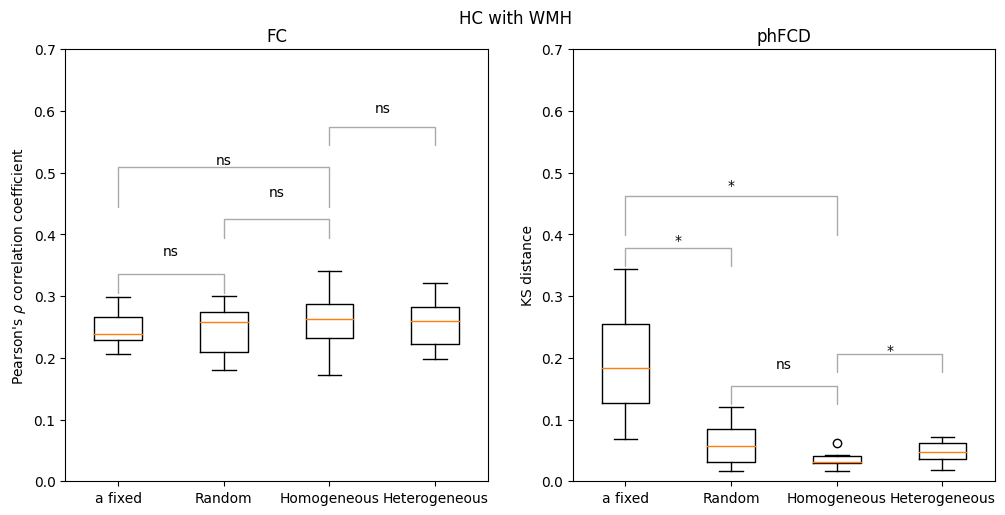

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))

x_ticks = [1, 2, 3, 4]

axs[0].boxplot([best_FC_a_fixed_HC_with_WMH, best_FC_random_HC_with_WMH, best_FC_homogeneous_HC_with_WMH, best_FC_heterogeneous_HC_with_WMH]);
axs[0].set_xticks(x_ticks);
axs[0].set_xticklabels(['a fixed', 'Random', 'Homogeneous', 'Heterogeneous']);

axs[0].set_ylim(0, .7)
axs[0].set_ylabel(r"Pearson's $\rho$ correlation coefficient")
axs[0].set_title('FC')
axs[0].annotate("", xy=(1, HC_max_FC_aFixed_vs_random), xycoords='data',
           xytext=(2, HC_max_FC_aFixed_vs_random), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
axs[0].text(1.5, HC_max_FC_aFixed_vs_random + abs(HC_max_FC_aFixed_vs_random - HC_min_FC_aFixed_vs_random)*0.5, stars(HC_p_FC_aFixed_vs_random),
       horizontalalignment='center',
       verticalalignment='bottom')

axs[0].annotate("", xy=(2, HC_max_FC_homo_vs_random + 0.05), xycoords='data',
           xytext=(3, HC_max_FC_homo_vs_random + 0.05), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
axs[0].text(2.5, HC_max_FC_homo_vs_random + 0.05 + abs(HC_max_FC_homo_vs_random - HC_min_FC_homo_vs_random)*0.4, stars(HC_p_FC_homo_vs_random),
       horizontalalignment='center',
       verticalalignment='bottom')

axs[0].annotate("", xy=(1, HC_max_FC_aFixed_vs_homo + 0.1), xycoords='data',
        xytext=(3, HC_max_FC_aFixed_vs_homo + 0.1), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[0].text(2, HC_max_FC_aFixed_vs_homo + abs(HC_max_FC_aFixed_vs_homo - HC_min_FC_aFixed_vs_homo)*1, stars(HC_p_FC_aFixed_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')

axs[0].annotate("", xy=(3, HC_max_FC_hetero_vs_homo + 0.2), xycoords='data',
        xytext=(4, HC_max_FC_hetero_vs_homo + 0.2), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[0].text(3.5, HC_max_FC_hetero_vs_homo + abs(HC_max_FC_hetero_vs_homo - HC_min_FC_hetero_vs_homo)*1.5, stars(HC_p_FC_hetero_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')

axs[1].boxplot([best_phFCD_a_fixed_HC_with_WMH, best_phFCD_random_HC_with_WMH, best_phFCD_homogeneous_HC_with_WMH, best_phFCD_heterogeneous_HC_with_WMH]);
axs[1].set_xticks(x_ticks);
axs[1].set_xticklabels(['a fixed', 'Random', 'Homogeneous', 'Heterogeneous']);
axs[1].set_ylim(0, .7)
axs[1].set_ylabel("KS distance")
axs[1].set_title('phFCD')
axs[1].annotate("", xy=(1, HC_max_phFCD_aFixed_vs_random), xycoords='data',
           xytext=(2, HC_max_phFCD_aFixed_vs_random), textcoords='data',
           arrowprops=dict(arrowstyle='-', ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
axs[1].text(1.5, HC_max_phFCD_aFixed_vs_random + abs(HC_max_phFCD_aFixed_vs_random - HC_min_phFCD_aFixed_vs_random)*0.18, stars(HC_p_phFCD_aFixed_vs_random),
       horizontalalignment='center',
       verticalalignment='top')

axs[1].annotate("", xy=(2, HC_max_phFCD_homo_vs_random), xycoords='data',
           xytext=(3, HC_max_phFCD_homo_vs_random), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
axs[1].text(2.5, HC_max_phFCD_homo_vs_random + abs(HC_max_phFCD_homo_vs_random - HC_min_phFCD_homo_vs_random) * 0.78, stars(HC_p_phFCD_homo_vs_random),
       horizontalalignment='center',
       verticalalignment='top')

axs[1].annotate("", xy=(1, HC_max_phFCD_aFixed_vs_homo + 0.05), xycoords='data',
        xytext=(3, HC_max_phFCD_aFixed_vs_homo + 0.05), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[1].text(2, HC_max_phFCD_aFixed_vs_homo + abs(HC_max_phFCD_aFixed_vs_homo - HC_min_phFCD_aFixed_vs_homo)*0.38, stars(HC_p_phFCD_aFixed_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')


axs[1].annotate("", xy=(3, HC_max_phFCD_hetero_vs_homo + 0.10), xycoords='data',
        xytext=(4, HC_max_phFCD_hetero_vs_homo + 0.10), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[1].text(3.5, HC_max_phFCD_hetero_vs_homo + abs(HC_max_phFCD_hetero_vs_homo - HC_min_phFCD_hetero_vs_homo)*2.35, stars(HC_p_phFCD_hetero_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')


fig.subplots_adjust(bottom=-0.2)
fig.suptitle('HC with WMH')
plt.savefig(base_dir + '/Plots/boxplot_model_performances_HC_with_WMH.png', bbox_inches = "tight")


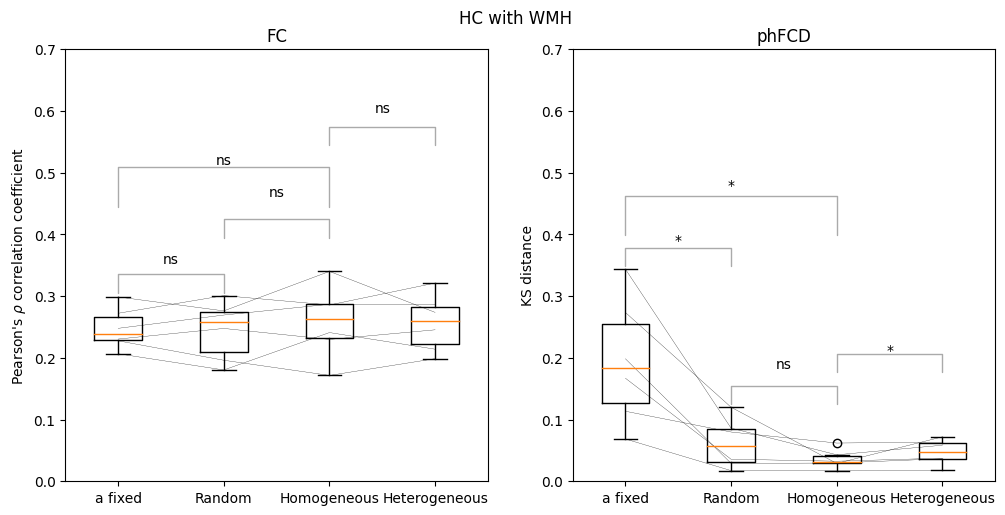

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))

axs[0].boxplot([best_FC_a_fixed_HC_with_WMH, best_FC_random_HC_with_WMH, best_FC_homogeneous_HC_with_WMH, best_FC_heterogeneous_HC_with_WMH]);
axs[0].set_xticks(x_ticks);
axs[0].set_xticklabels(['a fixed', 'Random', 'Homogeneous', 'Heterogeneous']);

for i in range(len(best_FC_a_fixed_HC_with_WMH)):
     axs[0].plot(x_ticks, [best_FC_a_fixed_HC_with_WMH[i], best_FC_random_HC_with_WMH[i], best_FC_homogeneous_HC_with_WMH[i], best_FC_heterogeneous_HC_with_WMH[i]], '-k', linewidth = 0.2)

axs[0].set_ylim(0, .7)
axs[0].set_ylabel(r"Pearson's $\rho$ correlation coefficient")
axs[0].set_title('FC')
axs[0].annotate("", xy=(1, HC_max_FC_aFixed_vs_random), xycoords='data',
           xytext=(2, HC_max_FC_aFixed_vs_random), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
axs[0].text(1.5, HC_max_FC_aFixed_vs_random + abs(HC_max_FC_aFixed_vs_random - HC_min_FC_aFixed_vs_random)*0.4, stars(HC_p_FC_aFixed_vs_random),
       horizontalalignment='center',
       verticalalignment='bottom')

axs[0].annotate("", xy=(2, HC_max_FC_homo_vs_random + 0.05), xycoords='data',
           xytext=(3, HC_max_FC_homo_vs_random + 0.05), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
axs[0].text(2.5, HC_max_FC_homo_vs_random + 0.05 + abs(HC_max_FC_homo_vs_random - HC_min_FC_homo_vs_random)*0.4, stars(HC_p_FC_homo_vs_random),
       horizontalalignment='center',
       verticalalignment='bottom')

axs[0].annotate("", xy=(1, HC_max_FC_aFixed_vs_homo + 0.1), xycoords='data',
        xytext=(3, HC_max_FC_aFixed_vs_homo + 0.1), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[0].text(2, HC_max_FC_aFixed_vs_homo + abs(HC_max_FC_aFixed_vs_homo - HC_min_FC_aFixed_vs_homo)*1, stars(HC_p_FC_aFixed_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')

axs[0].annotate("", xy=(3, HC_max_FC_hetero_vs_homo + 0.2), xycoords='data',
        xytext=(4, HC_max_FC_hetero_vs_homo + 0.2), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[0].text(3.5, HC_max_FC_hetero_vs_homo + abs(HC_max_FC_hetero_vs_homo - HC_min_FC_hetero_vs_homo)*1.5, stars(HC_p_FC_hetero_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')

axs[1].boxplot([best_phFCD_a_fixed_HC_with_WMH, best_phFCD_random_HC_with_WMH, best_phFCD_homogeneous_HC_with_WMH, best_phFCD_heterogeneous_HC_with_WMH]);
for i in range(len(best_phFCD_a_fixed_HC_with_WMH)):
     axs[1].plot(x_ticks, [best_phFCD_a_fixed_HC_with_WMH[i], best_phFCD_random_HC_with_WMH[i], best_phFCD_homogeneous_HC_with_WMH[i], best_phFCD_heterogeneous_HC_with_WMH[i]], '-k', linewidth = 0.2)

axs[1].set_xticks(x_ticks);
axs[1].set_xticklabels(['a fixed', 'Random', 'Homogeneous', 'Heterogeneous']);
axs[1].set_ylim(0, .7)
axs[1].set_ylabel("KS distance")
axs[1].set_title('phFCD')
axs[1].annotate("", xy=(1, HC_max_phFCD_aFixed_vs_random), xycoords='data',
           xytext=(2, HC_max_phFCD_aFixed_vs_random), textcoords='data',
           arrowprops=dict(arrowstyle='-', ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
axs[1].text(1.5, HC_max_phFCD_aFixed_vs_random + abs(HC_max_phFCD_aFixed_vs_random - HC_min_phFCD_aFixed_vs_random)*0.18, stars(HC_p_phFCD_aFixed_vs_random),
       horizontalalignment='center',
       verticalalignment='top')

axs[1].annotate("", xy=(2, HC_max_phFCD_homo_vs_random), xycoords='data',
           xytext=(3, HC_max_phFCD_homo_vs_random), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
axs[1].text(2.5, HC_max_phFCD_homo_vs_random + abs(HC_max_phFCD_homo_vs_random - HC_min_phFCD_homo_vs_random) * 0.78, stars(HC_p_phFCD_homo_vs_random),
       horizontalalignment='center',
       verticalalignment='top')

axs[1].annotate("", xy=(1, HC_max_phFCD_aFixed_vs_homo + 0.05), xycoords='data',
        xytext=(3, HC_max_phFCD_aFixed_vs_homo + 0.05), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[1].text(2, HC_max_phFCD_aFixed_vs_homo + abs(HC_max_phFCD_aFixed_vs_homo - HC_min_phFCD_aFixed_vs_homo)*0.38, stars(HC_p_phFCD_aFixed_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')


axs[1].annotate("", xy=(3, HC_max_phFCD_hetero_vs_homo + 0.10), xycoords='data',
        xytext=(4, HC_max_phFCD_hetero_vs_homo + 0.10), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[1].text(3.5, HC_max_phFCD_hetero_vs_homo + abs(HC_max_phFCD_hetero_vs_homo - HC_min_phFCD_hetero_vs_homo)*2.35, stars(HC_p_phFCD_hetero_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')


fig.subplots_adjust(bottom=-0.2)
fig.suptitle('HC with WMH')
plt.savefig(base_dir + '/Plots/boxplot_plus_spaghetti_model_performances_HC_with_WMH.png')


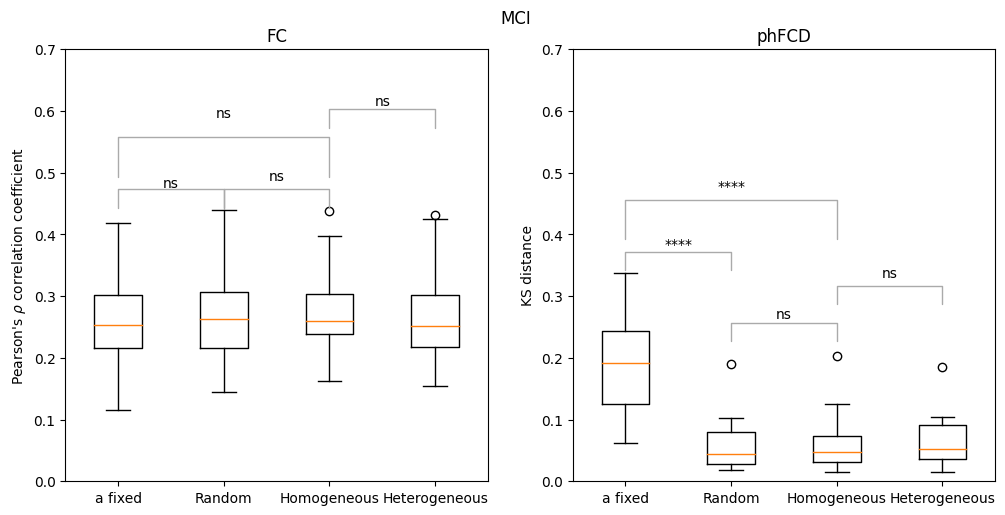

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
axs[0].boxplot([best_FC_a_fixed_MCI, best_FC_random_MCI, best_FC_homogeneous_MCI, best_FC_heterogeneous_MCI]);
axs[0].set_xticks(x_ticks);
axs[0].set_xticklabels(['a fixed', 'Random', 'Homogeneous', 'Heterogeneous']);
axs[0].set_ylim(0, .7)
axs[0].set_ylabel(r"Pearson's $\rho$ correlation coefficient")
axs[0].set_title('FC')
axs[0].annotate("", xy=(1, MCI_max_FC_aFixed_vs_random), xycoords='data',
        xytext=(2, MCI_max_FC_aFixed_vs_random), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[0].text(1.5, MCI_max_FC_aFixed_vs_random + abs(MCI_max_FC_aFixed_vs_random - MCI_min_FC_aFixed_vs_random)*0.1, stars(MCI_p_FC_aFixed_vs_random),
    horizontalalignment='center',
    verticalalignment='bottom')

axs[0].annotate("", xy=(2, MCI_max_FC_homo_vs_random), xycoords='data',
        xytext=(3, MCI_max_FC_homo_vs_random), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[0].text(2.5, MCI_max_FC_homo_vs_random + abs(MCI_max_FC_homo_vs_random - MCI_min_FC_homo_vs_random)*0.15, stars(HC_p_FC_homo_vs_random),
    horizontalalignment='center',
    verticalalignment='bottom')

axs[0].annotate("", xy=(1, MCI_max_FC_aFixed_vs_homo + 0.05), xycoords='data',
        xytext=(3, MCI_max_FC_aFixed_vs_homo + 0.05), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[0].text(2, MCI_max_FC_aFixed_vs_homo + abs(MCI_max_FC_aFixed_vs_homo - MCI_min_FC_aFixed_vs_homo)*0.45, stars(MCI_p_FC_aFixed_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')

axs[0].annotate("", xy=(3, MCI_max_FC_hetero_vs_homo + 0.13), xycoords='data',
        xytext=(4, MCI_max_FC_hetero_vs_homo + 0.13), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[0].text(3.5, MCI_max_FC_hetero_vs_homo + 0.08 + abs(MCI_max_FC_hetero_vs_homo - MCI_min_FC_hetero_vs_homo)*0.3, stars(MCI_p_FC_hetero_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')

axs[1].boxplot([best_phFCD_a_fixed_MCI, best_phFCD_random_MCI, best_phFCD_homogeneous_MCI, best_phFCD_heterogeneous_MCI]);
axs[1].set_xticks([1, 2, 3, 4]);
axs[1].set_xticklabels(['a fixed', 'Random', 'Homogeneous', 'Heterogeneous']);
axs[1].set_ylim(0, .7)
axs[1].set_ylabel('KS distance')
axs[1].set_title('phFCD')

axs[1].annotate("", xy=(1, MCI_max_phFCD_aFixed_vs_random), xycoords='data',
           xytext=(2, MCI_max_phFCD_aFixed_vs_random), textcoords='data',
           arrowprops=dict(arrowstyle='-', ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
axs[1].text(1.5, MCI_max_phFCD_aFixed_vs_random + abs(MCI_max_phFCD_aFixed_vs_random - MCI_min_phFCD_aFixed_vs_random)*0.18, stars(MCI_p_phFCD_aFixed_vs_random),
       horizontalalignment='center',
       verticalalignment='top')

axs[1].annotate("", xy=(2, MCI_max_phFCD_homo_vs_random + 0.02), xycoords='data',
           xytext=(3, MCI_max_phFCD_homo_vs_random + 0.02), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
axs[1].text(2.5, MCI_max_phFCD_homo_vs_random + abs(MCI_max_phFCD_homo_vs_random - MCI_min_phFCD_homo_vs_random) * 0.3, stars(MCI_p_phFCD_homo_vs_random),
       horizontalalignment='center',
       verticalalignment='bottom')

axs[1].annotate("", xy=(1, MCI_max_phFCD_aFixed_vs_homo + 0.05), xycoords='data',
        xytext=(3, MCI_max_phFCD_aFixed_vs_homo + 0.05), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[1].text(2, MCI_max_phFCD_aFixed_vs_homo + abs(MCI_max_phFCD_aFixed_vs_homo - MCI_min_phFCD_aFixed_vs_homo)*0.4, stars(MCI_p_phFCD_aFixed_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')


axs[1].annotate("", xy=(3, MCI_max_phFCD_hetero_vs_homo + 0.08), xycoords='data',
        xytext=(4, MCI_max_phFCD_hetero_vs_homo + 0.08), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[1].text(3.5, MCI_max_phFCD_hetero_vs_homo + abs(MCI_max_phFCD_hetero_vs_homo - MCI_min_phFCD_hetero_vs_homo)*0.65, stars(MCI_p_phFCD_hetero_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')

fig.subplots_adjust(bottom=-0.2)
fig.suptitle('MCI')
plt.savefig(base_dir + '/Plots/boxplot_model_performances_MCI.png', bbox_inches = "tight")


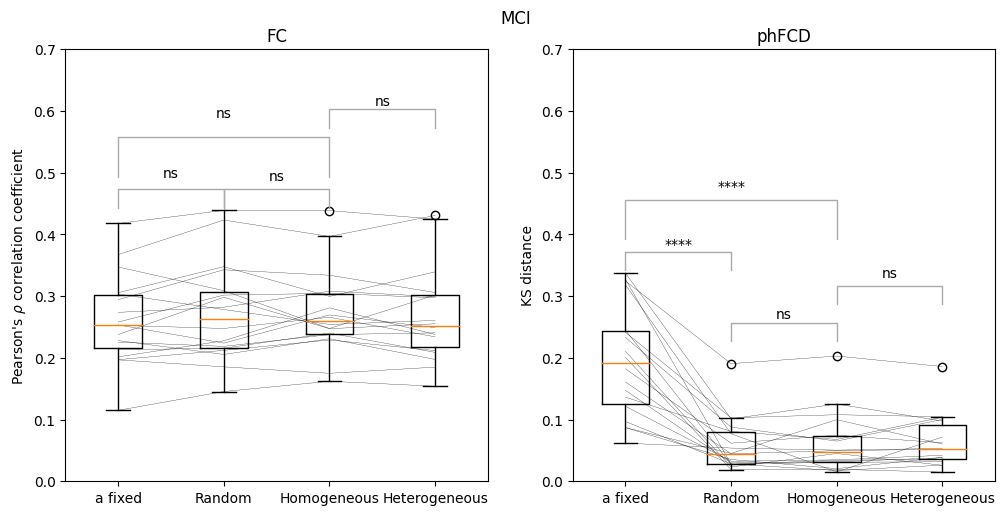

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
axs[0].boxplot([best_FC_a_fixed_MCI, best_FC_random_MCI, best_FC_homogeneous_MCI, best_FC_heterogeneous_MCI]);
for i in range(len(best_FC_a_fixed_MCI)):
     axs[0].plot(x_ticks, [best_FC_a_fixed_MCI[i], best_FC_random_MCI[i], best_FC_homogeneous_MCI[i], best_FC_heterogeneous_MCI[i]], '-k', linewidth = 0.2)

axs[0].set_xticks(x_ticks);
axs[0].set_xticklabels(['a fixed', 'Random', 'Homogeneous', 'Heterogeneous']);
axs[0].set_ylim(0, .7)
axs[0].set_ylabel(r"Pearson's $\rho$ correlation coefficient")
axs[0].set_title('FC')
axs[0].annotate("", xy=(1, MCI_max_FC_aFixed_vs_random), xycoords='data',
        xytext=(2, MCI_max_FC_aFixed_vs_random), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[0].text(1.5, MCI_max_FC_aFixed_vs_random + abs(MCI_max_FC_aFixed_vs_random - MCI_min_FC_aFixed_vs_random)*0.15, stars(MCI_p_FC_aFixed_vs_random),
    horizontalalignment='center',
    verticalalignment='bottom')

axs[0].annotate("", xy=(2, MCI_max_FC_homo_vs_random), xycoords='data',
        xytext=(3, MCI_max_FC_homo_vs_random), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[0].text(2.5, MCI_max_FC_homo_vs_random + abs(MCI_max_FC_homo_vs_random - MCI_min_FC_homo_vs_random)*0.15, stars(HC_p_FC_homo_vs_random),
    horizontalalignment='center',
    verticalalignment='bottom')

axs[0].annotate("", xy=(1, MCI_max_FC_aFixed_vs_homo + 0.05), xycoords='data',
        xytext=(3, MCI_max_FC_aFixed_vs_homo + 0.05), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[0].text(2, MCI_max_FC_aFixed_vs_homo + abs(MCI_max_FC_aFixed_vs_homo - MCI_min_FC_aFixed_vs_homo)*0.45, stars(MCI_p_FC_aFixed_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')

axs[0].annotate("", xy=(3, MCI_max_FC_hetero_vs_homo + 0.13), xycoords='data',
        xytext=(4, MCI_max_FC_hetero_vs_homo + 0.13), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[0].text(3.5, MCI_max_FC_hetero_vs_homo + 0.08 + abs(MCI_max_FC_hetero_vs_homo - MCI_min_FC_hetero_vs_homo)*0.3, stars(MCI_p_FC_hetero_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')



axs[1].boxplot([best_phFCD_a_fixed_MCI, best_phFCD_random_MCI, best_phFCD_homogeneous_MCI, best_phFCD_heterogeneous_MCI]);
for i in range(len(best_phFCD_a_fixed_MCI)):
     axs[1].plot(x_ticks, [best_phFCD_a_fixed_MCI[i], best_phFCD_random_MCI[i], best_phFCD_homogeneous_MCI[i], best_phFCD_heterogeneous_MCI[i]], '-k', linewidth = 0.2)

axs[1].set_xticks(x_ticks);
axs[1].set_xticklabels(['a fixed', 'Random', 'Homogeneous', 'Heterogeneous']);
axs[1].set_ylim(0, .7)
axs[1].set_ylabel('KS distance')
axs[1].set_title('phFCD')

axs[1].annotate("", xy=(1, MCI_max_phFCD_aFixed_vs_random), xycoords='data',
           xytext=(2, MCI_max_phFCD_aFixed_vs_random), textcoords='data',
           arrowprops=dict(arrowstyle='-', ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
axs[1].text(1.5, MCI_max_phFCD_aFixed_vs_random + abs(MCI_max_phFCD_aFixed_vs_random - MCI_min_phFCD_aFixed_vs_random)*0.18, stars(MCI_p_phFCD_aFixed_vs_random),
       horizontalalignment='center',
       verticalalignment='top')

axs[1].annotate("", xy=(2, MCI_max_phFCD_homo_vs_random + 0.02), xycoords='data',
           xytext=(3, MCI_max_phFCD_homo_vs_random + 0.02), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
axs[1].text(2.5, MCI_max_phFCD_homo_vs_random + abs(MCI_max_phFCD_homo_vs_random - MCI_min_phFCD_homo_vs_random) * 0.3, stars(MCI_p_phFCD_homo_vs_random),
       horizontalalignment='center',
       verticalalignment='bottom')

axs[1].annotate("", xy=(1, MCI_max_phFCD_aFixed_vs_homo + 0.05), xycoords='data',
        xytext=(3, MCI_max_phFCD_aFixed_vs_homo + 0.05), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[1].text(2, MCI_max_phFCD_aFixed_vs_homo + abs(MCI_max_phFCD_aFixed_vs_homo - MCI_min_phFCD_aFixed_vs_homo)*0.4, stars(MCI_p_phFCD_aFixed_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')


axs[1].annotate("", xy=(3, MCI_max_phFCD_hetero_vs_homo + 0.08), xycoords='data',
        xytext=(4, MCI_max_phFCD_hetero_vs_homo + 0.08), textcoords='data',
        arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                        connectionstyle="bar,fraction=0.2"))
axs[1].text(3.5, MCI_max_phFCD_hetero_vs_homo + abs(MCI_max_phFCD_hetero_vs_homo - MCI_min_phFCD_hetero_vs_homo)*0.65, stars(MCI_p_phFCD_hetero_vs_homo),
    horizontalalignment='center',
    verticalalignment='bottom')

fig.subplots_adjust(bottom=-0.2)
fig.suptitle('MCI')
plt.savefig(base_dir + '/Plots/boxplot_plus_spaghetti_model_performances_MCI.png')


In [ ]:
import pingouin as pg


# Calculate ANOVA repeated measures for FC in HC with WMH
df_results_FC_HC_with_WMH = np.concatenate([best_FC_a_fixed_HC_with_WMH, best_FC_random_HC_with_WMH, best_FC_homogeneous_HC_with_WMH, best_FC_heterogeneous_HC_with_WMH])
df_subjects_FC_HC_with_WMH = np.tile(np.arange(len(best_FC_a_fixed_HC_with_WMH)), 4)
df_models_FC_HC_with_WMH = np.repeat([1,2,3,4], len(best_FC_a_fixed_HC_with_WMH))

df_FC_HC_with_WMH = pd.DataFrame({'subject': df_subjects_FC_HC_with_WMH, 'models': df_models_FC_HC_with_WMH, 
                                 'results': df_results_FC_HC_with_WMH})


RM_anova_FC_HC_with_WMH = pg.rm_anova(dv='results', 
         within='models', 
         subject = 'subject',
         data=df_FC_HC_with_WMH,
         detailed=True)

# pairwise t-tests with Holm correction
post_hoc_FC_HC_with_WMH = pg.pairwise_tests(dv='results', 
                   within='models',
                   subject = 'subject', 
                   padjust='holm', 
                   data=df_FC_HC_with_WMH)

# Calculate ANOVA repeated measures for phFCD in HC with WMH
df_results_phFCD_HC_with_WMH = np.concatenate([best_phFCD_a_fixed_HC_with_WMH, best_phFCD_random_HC_with_WMH, best_phFCD_homogeneous_HC_with_WMH, best_phFCD_heterogeneous_HC_with_WMH])
df_subjects_phFCD_HC_with_WMH = np.tile(np.arange(len(best_phFCD_a_fixed_HC_with_WMH)), 4)
df_models_phFCD_HC_with_WMH = np.repeat([1,2,3,4], len(best_FC_a_fixed_HC_with_WMH))

df_phFCD_HC_with_WMH = pd.DataFrame({'subject': df_subjects_phFCD_HC_with_WMH, 'models': df_models_phFCD_HC_with_WMH, 
                                 'results': df_results_phFCD_HC_with_WMH})

RM_anova_phFCD_HC_with_WMH = pg.rm_anova(dv='results', 
         within='models', 
         subject = 'subject',
         data=df_phFCD_HC_with_WMH,
         detailed=True)

# pairwise t-tests with Holm correction
post_hoc_phFCD_HC_with_WMH = pg.pairwise_tests(dv='results', 
                   within='models',
                   subject = 'subject', 
                   padjust='holm', 
                   data=df_phFCD_HC_with_WMH)

# Calculate ANOVA repeated measures for FC in MCI
df_results_FC_MCI = np.concatenate([best_FC_a_fixed_MCI, best_FC_random_MCI, best_FC_homogeneous_MCI, best_FC_heterogeneous_MCI])
df_subjects_FC_MCI = np.tile(np.arange(len(best_FC_a_fixed_MCI)), 4)
df_models_FC_MCI = np.repeat([1,2,3,4], len(best_phFCD_a_fixed_MCI))

df_FC_MCI = pd.DataFrame({'subject': df_subjects_FC_MCI, 'models': df_models_FC_MCI, 
                                 'results': df_results_FC_MCI})


RM_anova_FC_MCI = pg.rm_anova(dv='results', 
         within='models', 
         subject = 'subject',
         data=df_FC_MCI,
         detailed=True)

# pairwise t-tests with Holm correction
post_hoc_FC_MCI = pg.pairwise_tests(dv='results', 
                   within='models',
                   subject = 'subject', 
                   padjust='holm', 
                   data=df_FC_MCI)

# Calculate ANOVA repeated measures for phFCD in MCI
df_results_phFCD_MCI = np.concatenate([best_phFCD_a_fixed_MCI, best_phFCD_random_MCI, best_phFCD_homogeneous_MCI, best_phFCD_heterogeneous_MCI])
df_subjects_phFCD_MCI = np.tile(np.arange(len(best_phFCD_a_fixed_MCI)), 4)
df_models_phFCD_MCI = np.repeat([1,2,3,4], len(best_phFCD_a_fixed_MCI))

df_phFCD_MCI = pd.DataFrame({'subject': df_subjects_phFCD_MCI, 'models': df_models_phFCD_MCI, 
                                 'results': df_results_phFCD_MCI})

RM_anova_phFCD_MCI = pg.rm_anova(dv='results', 
         within='models', 
         subject = 'subject',
         data=df_phFCD_MCI,
         detailed=True)

# pairwise t-tests with Holm correction
post_hoc_phFCD_MCI = pg.pairwise_tests(dv='results', 
                   within='models',
                   subject = 'subject', 
                   padjust='holm', 
                   data=df_phFCD_MCI)

/home/riccardo/anaconda3/envs/neurolib/lib/python3.9/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/riccardo/anaconda3/envs/neurolib/lib/python3.9/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/riccardo/anaconda3/envs/neurolib/lib/python3.9/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/riccardo/anaconda3/envs/

Text(2000, 0.4, "Spearman's rho 0.145")

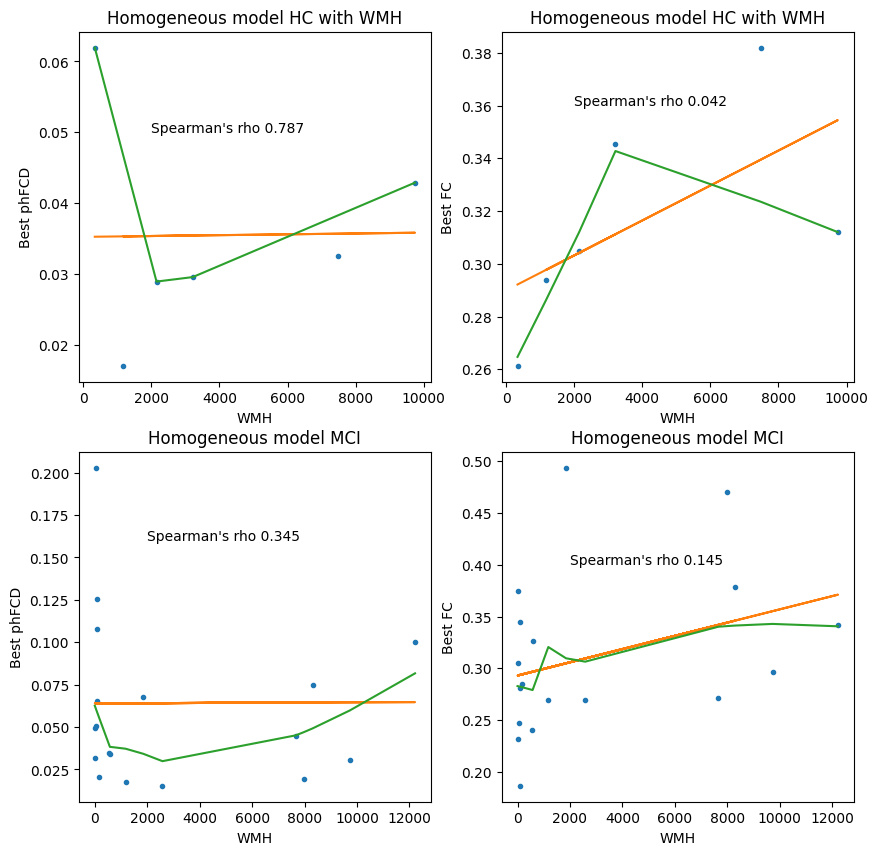

In [ ]:
fig, axis = plt.subplots(2,2, figsize = (10,10))

homo_best_phFCD_HC_with_WMH = []
homo_best_FC_HC_with_WMH = []

for i, v in homo_best_parms_dict_HC_with_WMH.items():
    homo_best_phFCD_HC_with_WMH.append(v['phFCD'][0])
    homo_best_FC_HC_with_WMH.append(v['FC'][0])


axis[0][0].plot(WMH_HC_with_WMH, homo_best_phFCD_HC_with_WMH, '.')
m00, b00 = np.polyfit(WMH_HC_with_WMH, homo_best_phFCD_HC_with_WMH, 1)
axis[0][0].plot(WMH_HC_with_WMH, m00 * np.array(WMH_HC_with_WMH) + b00)
axis[0][0].set_xlabel('WMH')
axis[0][0].set_ylabel('Best phFCD')
axis[0][0].set_title('Homogeneous model HC with WMH')

axis[0][1].plot(WMH_HC_with_WMH, homo_best_FC_HC_with_WMH, '.')
m01, b01 = np.polyfit(WMH_HC_with_WMH, homo_best_FC_HC_with_WMH, 1)
axis[0][1].plot(WMH_HC_with_WMH, m01 * np.array(WMH_HC_with_WMH) + b01)
axis[0][1].set_xlabel('WMH')
axis[0][1].set_ylabel('Best FC')
axis[0][1].set_title('Homogeneous model HC with WMH')


homo_best_phFCD_MCI = []
homo_best_FC_MCI = []

for i, v in homo_best_parms_dict_MCI.items():
    homo_best_phFCD_MCI.append(v['phFCD'][0])
    homo_best_FC_MCI.append(v['FC'][0])


axis[1][0].plot(WMH_MCI, homo_best_phFCD_MCI, '.')
m10, b10 = np.polyfit(WMH_MCI, homo_best_phFCD_MCI, 1)
axis[1][0].plot(WMH_MCI, m00 * np.array(WMH_MCI) + b10)
axis[1][0].set_xlabel('WMH')
axis[1][0].set_ylabel('Best phFCD')
axis[1][0].set_title('Homogeneous model MCI')

axis[1][1].plot(WMH_MCI, homo_best_FC_MCI, '.')
m11, b11 = np.polyfit(WMH_MCI, homo_best_FC_MCI, 1)
axis[1][1].plot(WMH_MCI, m11 * np.array(WMH_MCI) + b11)
axis[1][1].set_xlabel('WMH')
axis[1][1].set_ylabel('Best FC')
axis[1][1].set_title('Homogeneous model MCI')

lowess = sm.nonparametric.lowess

z00 = lowess(homo_best_phFCD_HC_with_WMH, WMH_HC_with_WMH)
z01 = lowess(homo_best_FC_HC_with_WMH, WMH_HC_with_WMH)
z10 = lowess(homo_best_phFCD_MCI, WMH_MCI)
z11 = lowess(homo_best_FC_MCI, WMH_MCI)

axis[0][0].plot(z00.T[0], z00.T[1])
axis[0][1].plot(z01.T[0], z01.T[1])
axis[1][0].plot(z10.T[0], z10.T[1])
axis[1][1].plot(z11.T[0], z11.T[1])

axis[0][0].text(2000, 0.05, f"Spearman's rho {round(ss.spearmanr(WMH_HC_with_WMH, homo_best_phFCD_HC_with_WMH)[1], 3)}")
axis[0][1].text(2000, 0.36, f"Spearman's rho {round(ss.spearmanr(WMH_HC_with_WMH, homo_best_FC_HC_with_WMH)[1], 3)}")
axis[1][0].text(2000, 0.16, f"Spearman's rho {round(ss.spearmanr(WMH_MCI, homo_best_phFCD_MCI)[1], 3)}")
axis[1][1].text(2000, 0.40, f"Spearman's rho {round(ss.spearmanr(WMH_MCI, homo_best_FC_MCI)[1], 3)}")

Text(2000, 0.4, "Spearman's rho 0.078")

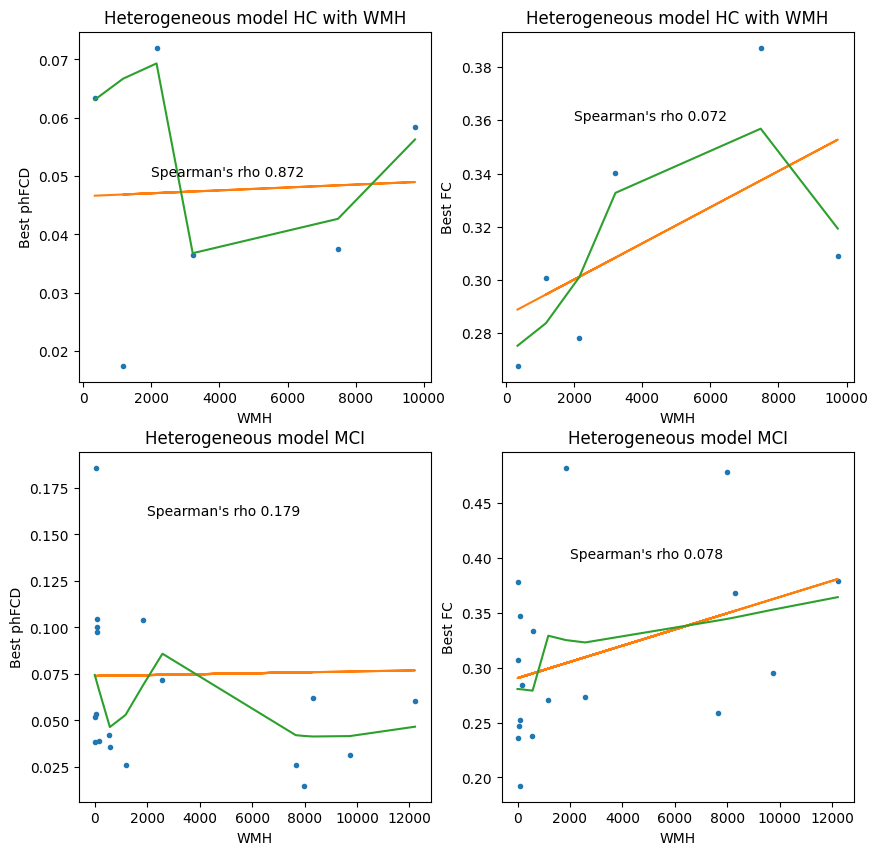

In [ ]:
fig, axis = plt.subplots(2,2, figsize = (10,10))

hetero_best_phFCD_HC_with_WMH = []
hetero_best_FC_HC_with_WMH = []

for i, v in hetero_best_parms_dict_HC_with_WMH.items():
    hetero_best_phFCD_HC_with_WMH.append(v['phFCD'][0])
    hetero_best_FC_HC_with_WMH.append(v['FC'][0])


axis[0][0].plot(WMH_HC_with_WMH, hetero_best_phFCD_HC_with_WMH, '.')
m00, b00 = np.polyfit(WMH_HC_with_WMH, hetero_best_phFCD_HC_with_WMH, 1)
axis[0][0].plot(WMH_HC_with_WMH, m00 * np.array(WMH_HC_with_WMH) + b00)
axis[0][0].set_xlabel('WMH')
axis[0][0].set_ylabel('Best phFCD')
axis[0][0].set_title('Heterogeneous model HC with WMH')

axis[0][1].plot(WMH_HC_with_WMH, hetero_best_FC_HC_with_WMH, '.')
m01, b01 = np.polyfit(WMH_HC_with_WMH, hetero_best_FC_HC_with_WMH, 1)
axis[0][1].plot(WMH_HC_with_WMH, m01 * np.array(WMH_HC_with_WMH) + b01)
axis[0][1].set_xlabel('WMH')
axis[0][1].set_ylabel('Best FC')
axis[0][1].set_title('Heterogeneous model HC with WMH')


hetero_best_phFCD_MCI = []
hetero_best_FC_MCI = []

for i, v in hetero_best_parms_dict_MCI.items():
    hetero_best_phFCD_MCI.append(v['phFCD'][0])
    hetero_best_FC_MCI.append(v['FC'][0])


axis[1][0].plot(WMH_MCI, hetero_best_phFCD_MCI, '.')
m10, b10 = np.polyfit(WMH_MCI, hetero_best_phFCD_MCI, 1)
axis[1][0].plot(WMH_MCI, m00 * np.array(WMH_MCI) + b10)
axis[1][0].set_xlabel('WMH')
axis[1][0].set_ylabel('Best phFCD')
axis[1][0].set_title('Heterogeneous model MCI')

axis[1][1].plot(WMH_MCI, hetero_best_FC_MCI, '.')
m11, b11 = np.polyfit(WMH_MCI, hetero_best_FC_MCI, 1)
axis[1][1].plot(WMH_MCI, m11 * np.array(WMH_MCI) + b11)
axis[1][1].set_xlabel('WMH')
axis[1][1].set_ylabel('Best FC')
axis[1][1].set_title('Heterogeneous model MCI')

z00 = lowess(hetero_best_phFCD_HC_with_WMH, WMH_HC_with_WMH)
z01 = lowess(hetero_best_FC_HC_with_WMH, WMH_HC_with_WMH)
z10 = lowess(hetero_best_phFCD_MCI, WMH_MCI)
z11 = lowess(hetero_best_FC_MCI, WMH_MCI)

axis[0][0].plot(z00.T[0], z00.T[1])
axis[0][1].plot(z01.T[0], z01.T[1])
axis[1][0].plot(z10.T[0], z10.T[1])
axis[1][1].plot(z11.T[0], z11.T[1])

axis[0][0].text(2000, 0.05, f"Spearman's rho {round(ss.spearmanr(WMH_HC_with_WMH, hetero_best_phFCD_HC_with_WMH)[1], 3)}")
axis[0][1].text(2000, 0.36, f"Spearman's rho {round(ss.spearmanr(WMH_HC_with_WMH, hetero_best_FC_HC_with_WMH)[1], 3)}")
axis[1][0].text(2000, 0.16, f"Spearman's rho {round(ss.spearmanr(WMH_MCI, hetero_best_phFCD_MCI)[1], 3)}")
axis[1][1].text(2000, 0.40, f"Spearman's rho {round(ss.spearmanr(WMH_MCI, hetero_best_FC_MCI)[1], 3)}")

In [ ]:
WMH_HC = WMH_HC_with_WMH + WMH_HC

MannwhitneyuResult(statistic=80.5, pvalue=1.0)


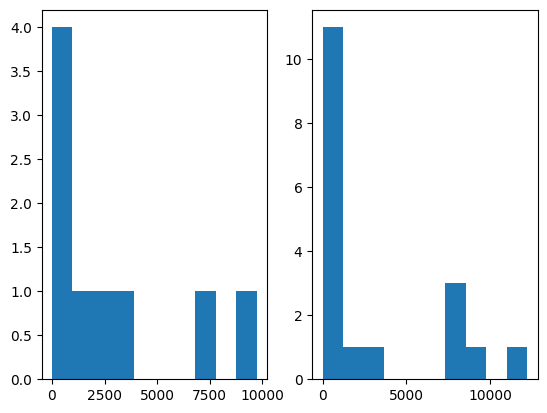

In [ ]:
print(f'{ss.mannwhitneyu(np.array(WMH_HC), np.array(WMH_MCI))}')

WMH_HC_arr = np.array(WMH_HC)
WMH_MCI_arr = np.array(WMH_MCI)

fig, axs = plt.subplots(1,2)
axs[0].hist(WMH_HC_arr)
axs[1].hist(WMH_MCI_arr);

In [ ]:
WMH_normalized_all_file = open('/home/riccardo/ADNI_Hopf/Results/normalized_WMH_lobewise_all.pkl', 'rb')
WMH_normalized_all = pickle.load(WMH_normalized_all_file)

In [ ]:
frontal_idx = np.arange(28)
parietal_idx = np.arange(28, 36)
temporal_idx = np.arange(36, 52)
occipital_idx = np.arange(52, 64)
cingulate_idx = np.arange(64, 78)


frontal_vols = []
parietal_vols = []
temporal_vols = []
occipital_vols = []
cingulate_vols = []

for k, v in WMH_normalized_all.items():
    frontal_vols.append(v[frontal_idx])
    parietal_vols.append(v[parietal_idx])
    temporal_vols.append(v[temporal_idx])
    occipital_vols.append(v[occipital_idx])
    cingulate_vols.append(v[cingulate_idx])


frontal_vols = np.array(frontal_vols)
parietal_vols = np.array(parietal_vols)
temporal_vols = np.array(temporal_vols)
occipital_vols = np.array(occipital_vols)
cingulate_vols = np.array(cingulate_vols)
    

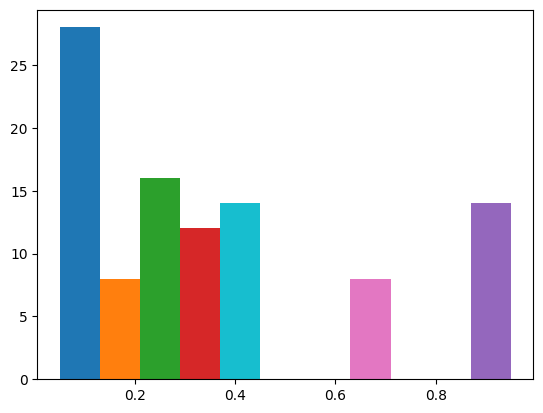

In [ ]:
for k, v in WMH_normalized_all.items():
    plt.hist([v[frontal_idx], v[parietal_idx], v[temporal_idx], v[occipital_idx], v[cingulate_idx]])